In [1]:
"""
Project: Multi-Asset Financial Data Pipeline for Generative and RL Models
Author: Dominic Ranelli

Result:
    Daily panel combining:
        - CRSP-like equity micro data (prices, returns, volume)
        - Compustat-like quarterly fundamentals (mapped to PERMNO, forward-filled to daily
        - FRED macro factors (rates, inflation, unemployment, stress)
        - Dukascopy FX data (major USD crosses)

    The resulting panel is the foundation for:
        - Generative models (Wavelet-DDPM) of multi-asset returns
        - Multi-agent portfolio RL with macro and regime conditioning

Design principles:
    - No look-ahead bias: fundamentals and macro information are aligned on a daily calendar with correct lags
    - Explicit, inspectable transformations: all cleaning steps done in pandas with clear equations shown
    - Seperation of concerns: Cleaning -> merging -> feature engineering
"""

'\nProject: Multi-Asset Financial Data Pipeline for Generative and RL Models\nAuthor: Dominic Ranelli\n\nResult:\n    Daily panel combining:\n        - CRSP-like equity micro data (prices, returns, volume)\n        - Compustat-like quarterly fundamentals (mapped to PERMNO, forward-filled to daily\n        - FRED macro factors (rates, inflation, unemployment, stress)\n        - Dukascopy FX data (major USD crosses)\n\n    The resulting panel is the foundation for:\n        - Generative models (Wavelet-DDPM) of multi-asset returns\n        - Multi-agent portfolio RL with macro and regime conditioning\n\nDesign principles:\n    - No look-ahead bias: fundamentals and macro information are aligned on a daily calendar with correct lags\n    - Explicit, inspectable transformations: all cleaning steps done in pandas with clear equations shown\n    - Seperation of concerns: Cleaning -> merging -> feature engineering\n'

In [2]:
# Imports
import pandas as pd
import numpy as np

In [3]:
# Daily micro data (CRSP)
daily_micro_data = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Micro-data/data1.csv")
# Columns: PERMNO, date, TICKER, COMNAM, PAYDT, DLRET, RET, BIDLO, ASKHI, VOL, RETX, OPENPRC, vwretd, PRC

# Quarterly micro data (Compustat)
quarterly_micro_data = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Micro-data/data2.csv")
# Columns: costat, curcdq, indfmt, consol, tic, datadate, gvkey, datafqtr, atq, ceqq, epsiq, ltq, niq, revtq, seqq, capxy

/var/folders/m0/h8g4_jcd3z70tgy7kq2rbtgr0000gn/T/ipykernel_85739/920534020.py:2: DtypeWarning: Columns (10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  daily_micro_data = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Micro-data/data1.csv")


In [4]:
# Data exploration:
daily_micro_data.head()


,PERMNO,date,TICKER,COMNAM,PAYDT,DLRETX,DLRET,BIDLO,ASKHI,VOL,RET,OPENPRC,RETX,vwretd
0,10104,1996-01-02,ORCL,ORACLE CORP,NaN,NaN,NaN,42.375,43.375,3385229.0,0.020649,42.750,0.020649,0.006606
1,10104,1996-01-03,ORCL,ORACLE CORP,NaN,NaN,NaN,41.250,43.375,4141569.0,-0.046243,42.500,-0.046243,-0.000155
2,10104,1996-01-04,ORCL,ORACLE CORP,NaN,NaN,NaN,39.625,41.625,9626544.0,-0.012121,41.625,-0.012121,-0.007674
3,10104,1996-01-05,ORCL,ORACLE CORP,NaN,NaN,NaN,39.750,43.000,6214821.0,0.052147,40.125,0.052147,-0.001023
4,10104,1996-01-08,ORCL,ORACLE CORP,NaN,NaN,NaN,42.125,43.625,936864.0,-0.014577,43.500,-0.014577,0.002686


In [5]:
daily_micro_data.shape


(1544118, 14)

In [6]:
# Data integration
# Convert date to datetime and sort by
daily_micro_data['date'] = pd.to_datetime(daily_micro_data['date'])

# Sort by ticker and date
daily_micro_data = daily_micro_data.sort_values(['TICKER', 'date'])

In [7]:
# Forcing values into numeric types
import numpy as np
for col in ['RET', 'RETX', 'DLRET']:
    daily_micro_data[col] = pd.to_numeric(daily_micro_data[col], errors = 'coerce')



In [8]:
# Dropping zero-prices
daily_micro_data['PRC'] = daily_micro_data['OPENPRC'].abs()


In [9]:
# Finding log returns
daily_micro_data['RETX'] = daily_micro_data['RETX'].fillna(0.0)
daily_micro_data['DLRET'] = daily_micro_data['DLRET'].fillna(0.0)

daily_micro_data['ret_clean'] = (
    (1.0 + daily_micro_data['RETX']) * (1.0 + daily_micro_data['DLRET']) - 1.0)

# Finding log returns
daily_micro_data['logret'] = np.log1p(daily_micro_data['ret_clean'])

In [10]:
# Building calendar, containing all trading days in sample
master_calendar = pd.DataFrame(
    index = pd.date_range(
        start = daily_micro_data['date'].min(),
        end = daily_micro_data['date'].max(),
        freq = 'D'))
master_calendar.index.name = 'date'

In [11]:
# Dropping date duplicates
daily_micro_data = daily_micro_data.drop_duplicates(subset=['date', 'PERMNO'])
len(daily_micro_data)

1544110

In [15]:
# Restricting calendar to trading days, building master index with this in mind
master_calendar = pd.DataFrame(
    index = pd.date_range(
        start = daily_micro_data['date'].min(),
        end = daily_micro_data['date'].max(),
        freq = 'D'))
master_calendar.index.name = 'date'
master_calendar = master_calendar.loc[master_calendar.index.isin(daily_micro_data['date'].unique())]
master_index = return_matrix.index

In [16]:
# Building missingness matrix
missing_matrix = return_matrix.isna().astype(int)

In [17]:
return_matrix.head()

PERMNO,10104,10107,10182,10299,10302,10401,10657,10876,10890,11081,...,91883,91937,92020,92257,92293,92497,92765,92778,93002,93132
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,0.020439,0.022536,0.008298,0.000000,0.000000,0.039741,0.000000,0.000000,0.107630,0.028472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,-0.047346,-0.032557,0.007205,-0.093401,-0.050772,0.016560,-0.004820,-0.010811,0.059423,-0.035718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,-0.012195,0.005739,-0.023873,-0.028371,0.030772,-0.022141,-0.004843,-0.010930,-0.080043,-0.071594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,0.050833,-0.011511,-0.051735,0.021353,-0.030772,-0.001868,0.004842,0.074108,0.040822,0.030772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,-0.014684,-0.001448,0.000000,0.027780,0.020619,0.000000,-0.014599,-0.041672,0.019803,0.011300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Aligning each matrix to master calendar and filling missing dates
return_matrix = return_matrix.sort_index()
price_matrix = price_matrix.sort_index()
volume_matrix = volume_matrix.sort_index()

In [19]:
# Ensuring we are in the right place, shape wise
print(return_matrix.shape)
print(price_matrix.shape)
print(volume_matrix.shape)

return_matrix.head()
return_matrix.isna().mean().describe()

(7300, 349)
(7300, 349)
(7300, 349)


count    349.000000
mean       0.393920
std        0.339302
min        0.000000
25%        0.016301
50%        0.333699
75%        0.740548
max        0.987260
dtype: float64

In [20]:
daily_micro_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1544110 entries, 165438 to 954978
Data columns (total 17 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   PERMNO     1544110 non-null  int64         
 1   date       1544110 non-null  datetime64[ns]
 2   TICKER     1528183 non-null  object        
 3   COMNAM     1544106 non-null  object        
 4   PAYDT      8244 non-null     object        
 5   DLRETX     349 non-null      object        
 6   DLRET      1544110 non-null  float64       
 7   BIDLO      1527616 non-null  float64       
 8   ASKHI      1527616 non-null  float64       
 9   VOL        1527616 non-null  float64       
 10  RET        1527439 non-null  float64       
 11  OPENPRC    1509544 non-null  float64       
 12  RETX       1544110 non-null  float64       
 13  vwretd     1544110 non-null  float64       
 14  PRC        1509544 non-null  float64       
 15  ret_clean  1544110 non-null  float64       
 16  l

In [21]:
# Cleaning quarterly micro data

In [22]:
# Ensuring clean copy
quarterly_micro_data = quarterly_micro_data.copy()

# Converting dates to datetime
quarterly_micro_data['datadate'] = pd.to_datetime(quarterly_micro_data['datadate'])

# Bui;ding TICKER to PERMNO mapping from daily data
ticker_to_permno = (
    daily_micro_data.groupby('TICKER')['PERMNO'].agg(lambda s: s.value_counts().idxmax()))

# Mapping compustat ticker to PERMNO
quarterly_micro_data['PERMNO'] = quarterly_micro_data['tic'].map(ticker_to_permno)

# Dropping information w/ no mapping to PERMNO
quarterly_micro_data = quarterly_micro_data.dropna(subset = ['PERMNO'])
quarterly_micro_data['PERMNO'] = quarterly_micro_data['PERMNO'].astype(int)

# Sorting by PERMNO (permanent number)
quarterly_micro_data = quarterly_micro_data.sort_values(['PERMNO', 'datadate'])

In [23]:
numeric_cols = ['atq', 'ceqq', 'epspiq', 'ltq', 'niq', 'revtq', 'seqq', 'capxy']
for c in numeric_cols:
    quarterly_micro_data[c] = pd.to_numeric(quarterly_micro_data[c], errors = 'coerce')

In [24]:
quarterly_micro_data = quarterly_micro_data.drop_duplicates(subset=['datadate', 'PERMNO'])


In [25]:
# Creatug pivot for quarterly macro data

atq = quarterly_micro_data.pivot(
    index = 'datadate',
    columns = 'PERMNO',
    values = 'atq')
atq_daily = atq.reindex(master_index).ffill()

revtq_q = quarterly_micro_data.pivot(
    index = 'datadate',
    columns = 'PERMNO',
    values = 'revtq')
revtq_daily = revtq_q.reindex(master_index).ffill()

niq_q = quarterly_micro_data.pivot(
    index = 'datadate',
    columns = 'PERMNO',
    values = 'niq')
niq_daily = niq_q.reindex(master_index).ffill()

In [26]:
# Daily panels for each findamental

ceqq_q = quarterly_micro_data.pivot(index='datadate', columns='PERMNO', values='ceqq')
ceqq_daily = ceqq_q.reindex(master_index).ffill()

ltq_q = quarterly_micro_data.pivot(index='datadate', columns='PERMNO', values='ltq')
ltq_daily = ltq_q.reindex(master_index).ffill()

capx_q = quarterly_micro_data.pivot(index='datadate', columns='PERMNO', values='capxy')
capx_daily = capx_q.reindex(master_index).ffill()

In [27]:
# Stacking fundamental into multi-feature panel
fundamentals_daily = (pd.concat({
    'atq': atq_daily,
    'revtq': revtq_daily,
    'niq': niq_daily,
    'ceqq': ceqq_daily,
    'ltq': ltq_daily,
    'capxy': capx_daily
}, axis = 1))

In [28]:
equity_panel = pd.concat([price_matrix, return_matrix, volume_matrix, fundamentals_daily], axis = 1)

In [29]:
equity_panel.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7300 entries, 1996-01-02 to 2024-12-31
Columns: 2547 entries, 10104 to ('capxy', 93132)
dtypes: float64(2547)
memory usage: 141.9 MB


In [30]:
# Cleaning macro data

In [31]:
# Getting macro data from FRED
CPIAUCSL = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/CPIAUCSL.csv")
CPIFESL = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/CPILFESL.csv")
DGS2 = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/DGS2.csv")
DGS10 = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/DGS10.csv")
DTB3 = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/DTB3.csv")
FEDFUNDS = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/FEDFUNDS.csv")
STLFSI4 = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/STLFSI4.csv")
UNRATE = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-FREDDATE/UNRATE.csv")

In [32]:
# Column name aligned to series kkey
CPIAUCSL['date'] = pd.to_datetime(CPIAUCSL['observation_date'])
CPIAUCSL = CPIAUCSL.set_index('date')[['CPIAUCSL']]

In [33]:
CPIAUCSL = CPIAUCSL.reindex(master_calendar.index).ffill()

In [34]:
# Column name aligned to series kkey
CPIFESL['date'] = pd.to_datetime(CPIFESL['observation_date'])
CPIFESL = CPIFESL.set_index('date')[['CPILFESL']]
CPIFESL = CPIFESL.reindex(master_calendar.index).ffill()

In [35]:
CPIFESL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7300 entries, 1996-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPILFESL  7278 non-null   float64
dtypes: float64(1)
memory usage: 114.1 KB


In [36]:
# Column name aligned to series kkey
DGS2['date'] = pd.to_datetime(DGS2['observation_date'])
DGS2 = DGS2.set_index('date')[['DGS2']]
# Ensureing alignment to master calendar and foward filling for values to remain constant between observations
DGS2 = DGS2.reindex(master_calendar.index).ffill()

In [37]:
# Column name aligned to series kkey
DGS10['date'] = pd.to_datetime(DGS10['observation_date'])
DGS10 = DGS10.set_index('date')[['DGS10']]
# Ensureing alignment to master calendar and foward filling
DGS10 = DGS10.reindex(master_calendar.index).ffill()

In [38]:
# Column name aligned to series kkey
DTB3['date'] = pd.to_datetime(DTB3['observation_date'])
DTB3 = DTB3.set_index('date')[['DTB3']]
# Ensureing alignment to master calendar and foward filling
DTB3 = DTB3.reindex(master_calendar.index).ffill()

In [39]:
# Column name aligned to series kkey
FEDFUNDS['date'] = pd.to_datetime(FEDFUNDS['observation_date'])
FEDFUNDS = FEDFUNDS.set_index('date')[['FEDFUNDS']]
# Ensureing alignment to master calendar and foward filling
FEDFUNDS = FEDFUNDS.reindex(master_calendar.index).ffill()

In [40]:
# Column name aligned to series kkey
STLFSI4['date'] = pd.to_datetime(STLFSI4['observation_date'])
STLFSI4 = STLFSI4.set_index('date')[['STLFSI4']]
# Ensureing alignment to master calendar and foward filling
STLFSI4 = STLFSI4.reindex(master_calendar.index).ffill()

In [41]:
# Column name aligned to series kkey
UNRATE['date'] = pd.to_datetime(UNRATE['observation_date'])
UNRATE = UNRATE.set_index('date')[['UNRATE']]
# Ensureing alignment to master calendar and foward filling
UNRATE = UNRATE.reindex(master_calendar.index).ffill()

In [42]:
# Appending all information
macro_fred = CPIAUCSL.join([
    CPIFESL, DGS2, DGS10, DTB3, FEDFUNDS, STLFSI4, UNRATE])

In [43]:
# Ensuring observation date and forward filling dataset
macro_fred = macro_fred.loc[:, ~macro_fred.columns.str.contains('observation_date')]
macro_fred.index = pd.to_datetime(macro_fred.index)
macro_fred = macro_fred.sort_index()
macro_fred = macro_fred.ffill()

In [44]:
# Cleaning Dukascopy macro data

In [45]:
# Data import
GBPUSD = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/GBPUSD_1D_1996_2024.csv")


# Fixing all date formats inside the dataframe
GBPUSD["timestamp"] = pd.to_datetime(
    GBPUSD["UTC"].str.replace(" UTC", "", regex=False),
    format='mixed',
    dayfirst=True,
    utc=True
)

# Writing the corrected data back into the same file
GBPUSD.to_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/GBPUSD_1D_1996_2024.csv", index=False)

# Columns: timestamp, open, high, low, volume
GBPUSD['timestamp'] = pd.to_datetime(GBPUSD['timestamp'], utc=True)
GBPUSD['timestamp'] = GBPUSD['timestamp'].dt.tz_convert(None)

GBPUSD['date'] = GBPUSD['timestamp'].dt.normalize()
GBPUSD = GBPUSD.set_index('date')
GBPUSD = GBPUSD.drop(columns=['timestamp'])

GBPUSD = GBPUSD[GBPUSD.index.dayofweek < 5]

GBPUSD_daily = GBPUSD.resample('1D').agg({
    'Open':  'first',
    'High':  'max',
    'Low':   'min',
    'Close': 'last',
    'Volume': 'sum'
})
GBPUSD_daily = GBPUSD_daily.dropna(subset=['Close'])

# Aligning to master time index
GBPUSD_aligned = GBPUSD_daily.reindex(master_index)
GBPUSD_aligned[['Open','High','Low','Close', 'Volume']] = \
    GBPUSD_aligned[['Open','High','Low','Close', 'Volume']].ffill()

gbpusd_close = GBPUSD_aligned['Close'].rename('GBPUSD')
GBPUSD_aligned.head()

,Open,High,Low,Close,Volume
date,,,,,
1996-01-02,1.5474,1.5602,1.5417,1.5543,140303.66
1996-01-03,1.5545,1.5560,1.5483,1.5507,47151.23
1996-01-04,1.5507,1.5544,1.5420,1.5527,140303.66
1996-01-05,1.5517,1.5560,1.5458,1.5524,40251.05
1996-01-08,1.5500,1.5531,1.5469,1.5520,59801.56


In [46]:
AUDUSD = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/AUDUSD_1D_1996_2024.csv")

# Fixing all date formats inside the dataframe
AUDUSD["timestamp"] = pd.to_datetime(
    AUDUSD["UTC"].str.replace(" UTC", "", regex=False),
    format='mixed',
    dayfirst=True,
    utc=True
)

# Writing the corrected data back into the same file
AUDUSD.to_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/AUDUSD_1D_1996_2024.csv", index=False)

# Columns: timestamp, open, high, low, volume
AUDUSD['timestamp'] = pd.to_datetime(AUDUSD['timestamp'], utc=True)
AUDUSD['timestamp'] = AUDUSD['timestamp'].dt.tz_convert(None)

AUDUSD['date'] = AUDUSD['timestamp'].dt.normalize()
AUDUSD = AUDUSD.set_index('date')
AUDUSD = AUDUSD.drop(columns=['timestamp'])

AUDUSD = AUDUSD[AUDUSD.index.dayofweek < 5]

AUDUSD_daily = AUDUSD.resample('1D').agg({
    'Open':  'first',
    'High':  'max',
    'Low':   'min',
    'Close': 'last',
    'Volume': 'sum'
})
AUDUSD_daily = AUDUSD_daily.dropna(subset=['Close'])

# Aligning to master index
AUDUSD_aligned = AUDUSD_daily.reindex(master_index)
AUDUSD_aligned[['Open','High','Low','Close','Volume']] = \
    AUDUSD_aligned[['Open','High','Low','Close','Volume']].ffill()

audusd_close = AUDUSD_aligned['Close'].rename('AUDUSD')
AUDUSD_aligned.head()

,Open,High,Low,Close,Volume
date,,,,,
1996-01-02,0.7434,0.7457,0.7420,0.7442,96962.210814
1996-01-03,0.7444,0.7497,0.7442,0.7485,85554.891895
1996-01-04,0.7480,0.7485,0.7375,0.7393,49431.715317
1996-01-05,0.7387,0.7485,0.7382,0.7477,39925.616217
1996-01-08,0.7477,0.7483,0.7435,0.7477,95060.990994


In [47]:
JPYUSD = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/USDJPY_1D_1996_2024.csv")

# Fixing all date formats inside the dataframe
JPYUSD["timestamp"] = pd.to_datetime(
    JPYUSD["UTC"].str.replace(" UTC", "", regex=False),
    format='mixed',
    dayfirst=True,
    utc=True
)

# Writing the corrected data back into the same file
JPYUSD.to_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/USDJPY_1D_1996_2024.csv", index=False)

# Columns: timestamp, open, high, low, volume

JPYUSD['timestamp'] = pd.to_datetime(JPYUSD['timestamp'], utc=True)
JPYUSD['timestamp'] = JPYUSD['timestamp'].dt.tz_convert(None)

JPYUSD['date'] = JPYUSD['timestamp'].dt.normalize()
JPYUSD = JPYUSD.set_index('date')
JPYUSD = JPYUSD.drop(columns=['timestamp'])

JPYUSD = JPYUSD[JPYUSD.index.dayofweek < 5]

JPYUSD_daily = JPYUSD.resample('1D').agg({
    'Open':  'first',
    'High':  'max',
    'Low':   'min',
    'Close': 'last',
    'Volume': 'sum'
})
JPYUSD_daily = JPYUSD_daily.dropna(subset=['Close'])

# Aligning to master index
JPYUSD_aligned = JPYUSD_daily.reindex(master_index)
JPYUSD_aligned[['Open','High','Low','Close','Volume']] = \
    JPYUSD_aligned[['Open','High','Low','Close','Volume']].ffill()

jpyusd_close = JPYUSD_aligned['Close'].rename('JPYUSD')
JPYUSD_aligned.head()

,Open,High,Low,Close,Volume
date,,,,,
1996-01-02,103.43,104.00,103.12,103.89,10499.97
1996-01-03,103.94,105.00,103.80,104.97,10885.29
1996-01-04,104.92,106.58,104.60,105.23,11077.95
1996-01-05,105.25,105.41,104.37,105.36,5394.48
1996-01-08,105.58,105.78,105.08,105.13,4142.19


In [48]:
CHFUSD = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/USDCHF_1D_1996_2024.csv")

# Fixing all date formats inside the dataframe
CHFUSD["timestamp"] = pd.to_datetime(
    CHFUSD["UTC"].str.replace(" UTC", "", regex=False),
    format='mixed',
    dayfirst=True,
    utc=True
)

# Write the corrected data back into the same file
CHFUSD.to_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/USDCHF_1D_1996_2024.csv", index=False)

# Columns: timestamp, open, high, low, volume
CHFUSD['timestamp'] = pd.to_datetime(CHFUSD['timestamp'], utc=True)
CHFUSD['timestamp'] = CHFUSD['timestamp'].dt.tz_convert(None)

CHFUSD['date'] = CHFUSD['timestamp'].dt.normalize()
CHFUSD = CHFUSD.set_index('date')
CHFUSD = CHFUSD.drop(columns=['timestamp'])

CHFUSD = CHFUSD[CHFUSD.index.dayofweek < 5]

CHFUSD_daily = CHFUSD.resample('1D').agg({
    'Open':  'first',
    'High':  'max',
    'Low':   'min',
    'Close': 'last',
    'Volume': 'sum'
})
CHFUSD_daily = CHFUSD_daily.dropna(subset=['Close'])

# Aligning to master index
CHFUSD_aligned = CHFUSD_daily.reindex(master_index)
CHFUSD_aligned[['Open','High','Low','Close','Volume']] = \
    CHFUSD_aligned[['Open','High','Low','Close','Volume']].ffill()

chfusd_close = CHFUSD_aligned['Close'].rename('CHFUSD')
CHFUSD_aligned.head()

,Open,High,Low,Close,Volume
date,,,,,
1996-01-02,1.1534,1.1597,1.1489,1.1588,13759.29
1996-01-03,1.1587,1.1662,1.1560,1.1648,22122.78
1996-01-04,1.1650,1.1777,1.1610,1.1628,33723.75
1996-01-05,1.1627,1.1677,1.1570,1.1614,19694.67
1996-01-08,1.1652,1.1657,1.1596,1.1620,33993.54


In [49]:
CADUSD = pd.read_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/USDCAD_1D_1996_2024.csv")

# Fix all date formats inside the dataframe
CADUSD["timestamp"] = pd.to_datetime(
    CADUSD["UTC"].str.replace(" UTC", "", regex=False),
    format='mixed',
    dayfirst=True,
    utc=True
)

# Write the corrected data back into the same file
CADUSD.to_csv("/Users/dominicranelli/Desktop/BigProject/Macro-Daka/USDCAD_1D_1996_2024.csv", index=False)

# Columns: timestamp, open, high, low, volume
CADUSD['timestamp'] = pd.to_datetime(CADUSD['timestamp'], utc=True)
CADUSD['timestamp'] = CADUSD['timestamp'].dt.tz_convert(None)

CADUSD['date'] = CADUSD['timestamp'].dt.normalize()
CADUSD = CADUSD.set_index('date')
CADUSD = CADUSD.drop(columns=['timestamp'])

CADUSD = CADUSD[CADUSD.index.dayofweek < 5]

CADUSD_daily = CADUSD.resample('1D').agg({
    'Open':  'first',
    'High':  'max',
    'Low':   'min',
    'Close': 'last',
    'Volume': 'sum'
})
CADUSD_daily = CADUSD_daily.dropna(subset=['Close'])

# Aligning to master index
CADUSD_aligned = CADUSD_daily.reindex(master_index)
CADUSD_aligned[['Open','High','Low','Close','volume']] = \
    CADUSD_aligned[['Open','High','Low','Close','Volume']].ffill()

cadusd_close = CADUSD_aligned['Close'].rename('CADUSD')
CADUSD_aligned.head()

,Open,High,Low,Close,Volume,volume
date,,,,,,
1996-01-02,1.3640,1.3652,1.3542,1.3544,223572.797,223572.797
1996-01-03,1.3542,1.3559,1.3521,1.3537,110847.017,110847.017
1996-01-04,1.3535,1.3567,1.3512,1.3559,231087.849,231087.849
1996-01-05,1.3560,1.3614,1.3555,1.3582,184118.774,184118.774
1996-01-08,1.3582,1.3644,1.3570,1.3642,118362.069,118362.069


In [50]:
# Combining all FX tables
macro_duka_prices = pd.concat([gbpusd_close, audusd_close, jpyusd_close, chfusd_close, cadusd_close], axis=1)

fx_close = pd.DataFrame({
    'CADUSD': CADUSD_aligned['Close'],
    'CHFUSD': CHFUSD_aligned['Close'],
    'JPYUSD': JPYUSD_aligned['Close'],
    'AUDUSD': AUDUSD_aligned['Close'],
    'GBPUSD': GBPUSD_aligned['Close']})

fx_close.shape

(7300, 5)

In [51]:
# Computing FX log returns:

We will now compute the logarithmic returns for foreign exchange values. Logarithmic returns show us the differences in prices between two days within the market timeline. This metric will show show sudden crashes in foreign exchange prices, as well as general market flow day-to-day. 

$r_t^{FX} = log(P_t/P_{t-1})$

In [52]:
macro_duka_returns = np.log(fx_close / fx_close.shift(1))
macro_duka_returns.columns = [c + 'Returns' for c in macro_duka_returns.columns]

In [53]:
macro_duka_returns = macro_duka_returns.reindex(master_index)

In [54]:
macro_duka_returns = macro_duka_returns.fillna(0)

macro_duka_returns

,CADUSDReturns,CHFUSDReturns,JPYUSDReturns,AUDUSDReturns,GBPUSDReturns
date,,,,,
1996-01-02,0.000000,0.000000,0.000000,0.000000,0.000000
1996-01-03,-0.000517,0.005164,0.010342,0.005761,-0.002319
1996-01-04,0.001624,-0.001719,0.002474,-0.012367,0.001289
1996-01-05,0.001695,-0.001205,0.001235,0.011298,-0.000193
1996-01-08,0.004408,0.000516,-0.002185,0.000000,-0.000258
...,...,...,...,...,...
2024-12-24,-0.001741,0.001179,-0.000796,-0.002743,-0.001094
2024-12-26,0.004194,-0.000678,0.004498,-0.000514,0.000711
2024-12-27,-0.000069,0.003221,0.000000,-0.001270,0.003514


In [55]:
# Full macro dataset
full_macro = macro_fred.join(macro_duka_prices)

In [56]:
full_macro.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7300 entries, 1996-01-02 to 2024-12-31
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPIAUCSL  7278 non-null   float64
 1   CPILFESL  7278 non-null   float64
 2   DGS2      7300 non-null   float64
 3   DGS10     7300 non-null   float64
 4   DTB3      7300 non-null   float64
 5   FEDFUNDS  7278 non-null   float64
 6   STLFSI4   7297 non-null   float64
 7   UNRATE    7278 non-null   float64
 8   GBPUSD    7300 non-null   float64
 9   AUDUSD    7300 non-null   float64
 10  JPYUSD    7300 non-null   float64
 11  CHFUSD    7300 non-null   float64
 12  CADUSD    7300 non-null   float64
dtypes: float64(13)
memory usage: 1.0 MB


In [57]:
df_list = [name for name, obj in globals().items() if isinstance(obj, pd.DataFrame)]
print(df_list)

['_', '___', 'daily_micro_data', 'quarterly_micro_data', '_6', 'master_calendar', 'price_matrix', 'return_matrix', 'volume_matrix', 'missing_matrix', '_17', 'atq', 'atq_daily', 'revtq_q', 'revtq_daily', 'niq_q', 'niq_daily', 'ceqq_q', 'ceqq_daily', 'ltq_q', 'ltq_daily', 'capx_q', 'capx_daily', 'fundamentals_daily', 'equity_panel', 'CPIAUCSL', 'CPIFESL', 'DGS2', 'DGS10', 'DTB3', 'FEDFUNDS', 'STLFSI4', 'UNRATE', 'macro_fred', 'GBPUSD', 'GBPUSD_daily', 'GBPUSD_aligned', '_45', 'AUDUSD', 'AUDUSD_daily', 'AUDUSD_aligned', '_46', 'JPYUSD', 'JPYUSD_daily', 'JPYUSD_aligned', '_47', 'CHFUSD', 'CHFUSD_daily', 'CHFUSD_aligned', '_48', 'CADUSD', 'CADUSD_daily', 'CADUSD_aligned', '_49', 'macro_duka_prices', 'fx_close', 'macro_duka_returns', '_54', 'full_macro']


In [58]:
# Final pannel to storeall asset information
final_pannel = pd.concat([
    price_matrix,
    return_matrix,
    volume_matrix,
    macro_fred,
    macro_duka_returns,
    fundamentals_daily], axis = 1).sort_index()

In [128]:
final_pannel.columns

Index([           10104,            10107,            10182,            10299,
                  10302,            10401,            10657,            10876,
                  10890,            11081,
       ...
       ('capxy', 91668), ('capxy', 91883), ('capxy', 91937), ('capxy', 92020),
       ('capxy', 92257), ('capxy', 92293), ('capxy', 92765), ('capxy', 93002),
       ('capxy', 93132),         'regime'],
      dtype='object', length=2561)

In [60]:
df_list = [name for name, obj in globals().items() if isinstance(obj, pd.DataFrame)]
print(df_list)

['_', '__', 'daily_micro_data', 'quarterly_micro_data', '_6', 'master_calendar', 'price_matrix', 'return_matrix', 'volume_matrix', 'missing_matrix', '_17', 'atq', 'atq_daily', 'revtq_q', 'revtq_daily', 'niq_q', 'niq_daily', 'ceqq_q', 'ceqq_daily', 'ltq_q', 'ltq_daily', 'capx_q', 'capx_daily', 'fundamentals_daily', 'equity_panel', 'CPIAUCSL', 'CPIFESL', 'DGS2', 'DGS10', 'DTB3', 'FEDFUNDS', 'STLFSI4', 'UNRATE', 'macro_fred', 'GBPUSD', 'GBPUSD_daily', 'GBPUSD_aligned', '_45', 'AUDUSD', 'AUDUSD_daily', 'AUDUSD_aligned', '_46', 'JPYUSD', 'JPYUSD_daily', 'JPYUSD_aligned', '_47', 'CHFUSD', 'CHFUSD_daily', 'CHFUSD_aligned', '_48', 'CADUSD', 'CADUSD_daily', 'CADUSD_aligned', '_49', 'macro_duka_prices', 'fx_close', 'macro_duka_returns', '_54', 'full_macro', 'final_pannel', '_59']


In [61]:
final_pannel.to_csv("/Users/dominicranelli/Desktop/BigProject/fullset.csv")

In [62]:
final_panel = final_pannel

In [63]:
equity_tickers = return_matrix.columns

$\sigma_{t,k} = \sqrt{{\frac{1}{k}\sum_{i=1}^{k}r^2_{t-i}}}$ 

We will begin to find the volatility using the returns matrix. We find 3 types of volatility per micro-economic asset: over 21 days (1 month asset volatility), 63 days(3 month asset volatility), and 252 days (1 year asset volatility .

In [64]:
# Caluculating volatility over dataset
volatility_21 = return_matrix.rolling(21).std()
volatility_63 = return_matrix.rolling(63).std()
volatility_252 = return_matrix.rolling(252).std()

volatility_21.columns = [f'vol21_{c}' for c in volatility_21.columns]
volatility_63.columns = [f'vol21_{c}' for c in volatility_63.columns]
volatility_252.columns = [f'vol21_{c}' for c in volatility_252.columns]


$MOM_{t,k} = log{P_t} - log{_{t-k}}$

In [65]:
# Calculating momentum
momemtum_21 = np.log(price_matrix).diff(21)
momemtum_63 = np.log(price_matrix).diff(63)
momemtum_252 = np.log(price_matrix).diff(252)

momemtum_21.columns = [f'mom_{c}' for c in momemtum_21.columns]
momemtum_63.columns = [f'mom_{c}' for c in momemtum_63.columns]
momemtum_252.columns = [f'mom_{c}' for c in momemtum_252.columns]


$DollarVol_{T,k} = P_{t,i} * V_{t,i}$

In [66]:
# Finding dollar volume
dollar_vol = price_matrix * volume_matrix

$ADV_{t,k,i} = \frac{1}{k}\sum_{j=1}^{k}DollarVol_{t-j,i}$

In [67]:
# Finding rolling means
adv_21 = dollar_vol.rolling(21).mean()
adv_63 = dollar_vol.rolling(63).mean()

adv_21.columns = [f'adv_21_{c}]' for c in adv_21.columns]
adv_63.columns = [f'adv_21_{c}]' for c in adv_63.columns]


$\beta_{i,t} = \frac{Cov(r_{i,t-k+1}, r_{m,t-k+1:t})}{Var(r_{m,t-k+1:t})}$

In [68]:
# Rolling beta to market
market_return = return_matrix.mean(axis = 1)

In [69]:
def rolling_beta(stock_returns, market, window = 63):
    cov = stock_returns.rolling(window).cov(market)
    var = market.rolling(window).var()
    return cov/var

beta_63 = return_matrix.apply(lambda col: rolling_beta(col, market_return), axis = 0)
beta_63.columns = [f'beta63_{c}' for c in beta_63.columns]

$\tilde{F} = F_{t-1}$ 

In [70]:
# Lagged fundamentals in order to avoid lookahead bias
fundamental_lagged = fundamentals_daily.shift(1)
fundamental_lagged.columns = [f'lag1_{c}' for c in fundamental_lagged.columns]

In [156]:
feature_panel = pd.concat([
    volatility_21, momemtum_63], axis = 1).sort_index()

feature_panel.head()

,vol21_10104,vol21_10107,vol21_10182,vol21_10299,vol21_10302,vol21_10401,vol21_10657,vol21_10876,vol21_10890,vol21_11081,...,mom_91883,mom_91937,mom_92020,mom_92257,mom_92293,mom_92497,mom_92765,mom_92778,mom_93002,mom_93132
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [158]:
ARTIFACT_DIR = "/Users/dominicranelli/Desktop/BigProject/artifacts"
feature_panel.to_parquet(os.path.join(ARTIFACT_DIR, "feature_panel_full2.parquet"))
os.makedirs(ARTIFACT_DIR, exist_ok=True)

In [145]:
feature_panel.reindex(master_index)
feature_panel.to_csv("/Users/dominicranelli/Desktop/BigProject/feature_panel2.csv")

,10104,10107,10182,10299,10302,10401,10657,10876,10890,11081,...,"lag1_('capxy', 91611)","lag1_('capxy', 91668)","lag1_('capxy', 91883)","lag1_('capxy', 91937)","lag1_('capxy', 92020)","lag1_('capxy', 92257)","lag1_('capxy', 92293)","lag1_('capxy', 92765)","lag1_('capxy', 93002)","lag1_('capxy', 93132)"
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,0.020439,0.022536,0.008298,0.000000,0.000000,0.039741,0.000000,0.000000,0.107630,0.028472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,-0.047346,-0.032557,0.007205,-0.093401,-0.050772,0.016560,-0.004820,-0.010811,0.059423,-0.035718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,-0.012195,0.005739,-0.023873,-0.028371,0.030772,-0.022141,-0.004843,-0.010930,-0.080043,-0.071594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,0.050833,-0.011511,-0.051735,0.021353,-0.030772,-0.001868,0.004842,0.074108,0.040822,0.030772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,-0.014684,-0.001448,0.000000,0.027780,0.020619,0.000000,-0.014599,-0.041672,0.019803,0.011300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,0.013332,0.009330,NaN,NaN,NaN,NaN,NaN,NaN,-0.007686,NaN,...,1212.537,75.358,1318.0,6628.0,4.0,199.0,17.0,235.3,548.0,281.3
2024-12-26,0.001574,-0.002781,NaN,NaN,NaN,NaN,NaN,NaN,0.021375,NaN,...,1212.537,75.358,1318.0,6628.0,4.0,199.0,17.0,235.3,548.0,281.3
2024-12-27,-0.015970,-0.017453,NaN,NaN,NaN,NaN,NaN,NaN,-0.030677,NaN,...,1212.537,75.358,1318.0,6628.0,4.0,199.0,17.0,235.3,548.0,281.3


In [74]:
# Full data engineering

In [75]:
# Calculating inflation rate year over year

$\pi_t^{YoY} = \frac{CPI_t - CPI_{t-252}}{CPI_{t-252}} = \frac{CPI_t}{CPI_{t-252}} - 1$

In [76]:
cpi = macro_fred['CPIAUCSL']
core_cpi = macro_fred['CPILFESL']

infl_yoy = cpi / cpi.shift(252) - 1.0
core_infl_yoy = core_cpi / core_cpi.shift(252) - 1.0

infl_yoy.name = 'infl_yoy'
core_infl_yoy.name  = 'core_infl_yoy'


Here $y_t^{(2)}$ and $y_t^{(10)}$ are th2 2-year and 10-year treasury yields where one can find the curve slope using:

$slope^{2s10s}_t = y_t^{(10)} - y_t^{(2)}$

In [77]:
y2 = macro_fred['DGS2']
y10 = macro_fred['DGS10']

slope_2s10s = y10 - y2
slope_2s10s.name = 'slope_2s10s'

If there is a steep curve, we know that we are in a period of growth or reflation regime. If there is an inverted curve we are in a recession risk regime. This is very important to the model, as it is conditioning on the market regime changes.

In [78]:
# Policy stance and front-end spread

We find the policy stance and front-end spread using the Fed Funds rate and 3-month treasury bill.

$pol_t = FEDFUNDS_t $

$frontspread_t = y_t^{(3m)} - FEDFUNDS_T $

In [79]:
ff = macro_fred['FEDFUNDS']
tb3 = macro_fred['DTB3']

policy_rate = ff.copy()
policy_rate.name = 'policy_rate'

front_spread = tb3 - ff
front_spread.name = 'front_spread'

First differences can remove unobserved, time-invariant characteristics. This is done here with the federal funds rate.
$\Delta FF = FEDFUNDS_t - FEDFUNDS_{t-1}$

In [80]:
ff_change = ff.diff()
ff_change.name = 'ff_change'

In [81]:
fsi = macro_fred['STLFSI4']
fsi.name = 'fsi'

unrate = macro_fred['UNRATE']
unrate.name = 'unrate'

In [82]:
# Foreign exchange data engineering

Foreign exchange volatility helps show how the market is shifting and whether the global or national economy is in a crisis. 
We have foreign exchange log returns, now we will build foreign exchange (FX) volatility. We will find realized volatility for pair $j$ at timestep $t$ for a 21 day period:

$\sigma^{FX}_{t,j,21} = \sqrt{\frac{1}{21}\sum^{21}_{i = 1}(r^{FX}_{t-i, j})^2} $

In [83]:
fx_ret = macro_duka_returns

fx_vol_21 = fx_ret.rolling(21).std()
fx_vol_21.columns = [f'{c}_vol21' for c in fx_vol_21.columns]


We can also view the 63-day foreign exchange momentum. This will allow models to 'feel' USD strength and weakness regimes.

$FXMOM_{t, j, 63} = \sum^{63}_{i = 1} r^{FX}_{t-1, j} - log ({\frac{P_{t-1,j}}{P_{t-63, j}})}$

In [84]:
fx_mom_63 = fx_ret.rolling(63).sum()
fx_mom_63.columns = [f'{c}_mom63' for c in fx_mom_63.columns]

Now we will build a macro-economic feature block:

In [85]:
macro_features = pd.concat([infl_yoy, core_infl_yoy, slope_2s10s, policy_rate, front_spread, ff_change, fsi, unrate, macro_duka_returns, fx_vol_21, fx_mom_63], axis = 1)

In [86]:
macro_features = macro_features.reindex(master_index)

Now we will standardize our macro-economic features for moedeling purposes. The diffusion model, RL, and PCA  will work best if the inputs are z-scored, where the mean of all features is 0 and and standard deviation is 1. So, for each feature $x_t$:

$\bar{x} = \frac{x_t-\mu_x}{\sigma_x}$, $\mu_x = \mathbb{E}[x_t]$, $\sigma^2_x = Var(x_t)$

In [87]:
macro_means = macro_features.mean()
macro_stds = macro_features.std(ddof=0)

macro_z = (macro_features - macro_means) / macro_stds
macro_z.columns = [f'z_{c}' for c in macro_z.columns]

Now the fun! To build our generative model, we do not need every feature. We simply need a compact conditioning vector. We will use:
$c_t = $
$
\begin{bmatrix}
\pi^{YoY}_t \\
slope^{2s10s}_t \\
policy rate_t \\
fsi_t \\
unrate_t \\
DXY proxy_t 
\end{bmatrix}
$

DXYproxy here is a weighted sum or mean of major USD FX returns.

In [88]:
dxy_proxy = macro_duka_returns.mean(axis = 1)
dxy_proxy.name = 'dxy_proxy'
dxy_mean = dxy_proxy.mean()
dxy_proxy_std = dxy_proxy.std(ddof=0)

dxy_z = (dxy_proxy - dxy_mean) / dxy_proxy_std


cond_features = pd.concat([macro_z['z_infl_yoy'],
                           macro_z['z_slope_2s10s'],
                           macro_z['z_policy_rate'],
                           macro_z['z_fsi'],
                           macro_z['z_unrate'],
                           dxy_z], axis = 1)

cond_features = cond_features.reindex(master_index)
cond_features.columns = ['c_infl', 'c_slope', 'c_rate', 'c_fsi', 'c_unemp', 'c_dxy']

In [89]:
cond_features

,c_infl,c_slope,c_rate,c_fsi,c_unemp,c_dxy
date,,,,,,
1996-01-02,NaN,-0.588887,NaN,NaN,NaN,0.002028
1996-01-03,NaN,-0.599388,NaN,NaN,NaN,1.582462
1996-01-04,NaN,-0.525880,NaN,NaN,NaN,-0.743889
1996-01-05,NaN,-0.515378,NaN,-0.467468,NaN,1.102091
1996-01-08,NaN,-0.525880,NaN,-0.467468,NaN,0.214784
...,...,...,...,...,...,...
2024-12-24,-0.0142,-0.714902,1.02585,-0.509969,-0.736564,-0.443331
2024-12-26,-0.0142,-0.735905,1.02585,-0.509969,-0.736564,0.705962
2024-12-27,-0.0142,-0.704401,1.02585,-0.630854,-0.736564,0.464626


Now we will perform PCA in order to summarize our macroeconomic conditions while keeping the majority of the explained variance. 

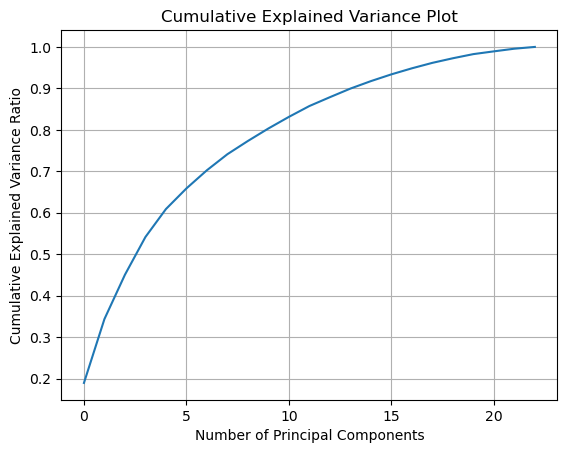

In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns

macro_for_pca = macro_z.dropna()

pca = PCA(n_components=None)
pca.fit(macro_for_pca)

macro_factors = pca.fit(macro_for_pca.values)



cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.plot(cumulative_variance)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()

In [91]:
pca = PCA(n_components = 5)

macro_factors = pca.fit_transform(macro_for_pca.values)

macro_factors = pd.DataFrame(
    macro_factors,
    index = macro_for_pca.index,
    columns = ['macro_f1', 'macro_f2', 'macro_f3', 'macro_f4', 'macro_f5'])

macro_factors = macro_factors.reindex(master_index).ffill().bfill()

In [92]:
macro_factors

,macro_f1,macro_f2,macro_f3,macro_f4,macro_f5
date,,,,,
1996-01-02,-0.787597,1.676264,-0.643306,-0.862902,-1.655688
1996-01-03,-0.787597,1.676264,-0.643306,-0.862902,-1.655688
1996-01-04,-0.787597,1.676264,-0.643306,-0.862902,-1.655688
1996-01-05,-0.787597,1.676264,-0.643306,-0.862902,-1.655688
1996-01-08,-0.787597,1.676264,-0.643306,-0.862902,-1.655688
...,...,...,...,...,...
2024-12-24,-0.313295,3.116327,0.031136,-1.015610,-1.474251
2024-12-26,-0.299332,3.405290,-0.265059,-0.994057,-1.631387
2024-12-27,-0.493903,3.323747,0.062295,-1.384988,-1.822390


In [99]:
feature_panel_full = pd.concat([
    macro_z,
    macro_factors,
    macro_features,
    cond_features], axis = 1).sort_index()

feature_panel_full

,z_infl_yoy,z_core_infl_yoy,z_slope_2s10s,z_policy_rate,z_front_spread,z_ff_change,z_fsi,z_unrate,z_CADUSDReturns,z_CHFUSDReturns,...,CHFUSDReturns_mom63,JPYUSDReturns_mom63,AUDUSDReturns_mom63,GBPUSDReturns_mom63,c_infl,c_slope,c_rate,c_fsi,c_unemp,c_dxy
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,NaN,NaN,-0.588887,NaN,NaN,NaN,NaN,NaN,-0.001617,0.005045,...,NaN,NaN,NaN,NaN,NaN,-0.588887,NaN,NaN,NaN,0.002028
1996-01-03,NaN,NaN,-0.599388,NaN,NaN,NaN,NaN,NaN,-0.103624,0.782118,...,NaN,NaN,NaN,NaN,NaN,-0.599388,NaN,NaN,NaN,1.582462
1996-01-04,NaN,NaN,-0.525880,NaN,NaN,NaN,NaN,NaN,0.318802,-0.253533,...,NaN,NaN,NaN,NaN,NaN,-0.525880,NaN,NaN,NaN,-0.743889
1996-01-05,NaN,NaN,-0.515378,NaN,NaN,NaN,-0.467468,NaN,0.332811,-0.176224,...,NaN,NaN,NaN,NaN,NaN,-0.515378,NaN,-0.467468,NaN,1.102091
1996-01-08,NaN,NaN,-0.525880,NaN,NaN,NaN,-0.467468,NaN,0.868144,0.082759,...,NaN,NaN,NaN,NaN,NaN,-0.525880,NaN,-0.467468,NaN,0.214784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-24,-0.0142,0.570911,-0.714902,1.02585,-0.608239,0.001612,-0.509969,-0.736564,-0.345108,0.182451,...,0.055857,0.081843,-0.090968,-0.061556,-0.0142,-0.714902,1.02585,-0.509969,-0.736564,-0.443331
2024-12-26,-0.0142,0.570911,-0.735905,1.02585,-0.730366,0.001612,-0.509969,-0.736564,0.825869,-0.097021,...,0.060376,0.083801,-0.102204,-0.068128,-0.0142,-0.735905,1.02585,-0.509969,-0.736564,0.705962
2024-12-27,-0.0142,0.570911,-0.704401,1.02585,-0.883026,0.001612,-0.630854,-0.736564,-0.015311,0.489663,...,0.070867,0.104217,-0.104750,-0.061694,-0.0142,-0.704401,1.02585,-0.630854,-0.736564,0.464626


In [135]:
feature_panel_full.head()
# import os
ARTIFACT_DIR = "/Users/dominicranelli/Desktop/BigProject/artifacts"
feature_panel_full.to_parquet(os.path.join(ARTIFACT_DIR, "feature_panel_full.parquet"))

Now we will find $v_t$ and dispersion

In [100]:
# 21-day rolling volatility
vol_21 = return_matrix.rolling(21).std()

market_vol = vol_21.mean(axis = 1)
market_vol.name = 'regime_mkt_vol21'

# mean across assets each day
cross_sec_mean_ret = return_matrix.mean(axis=1)

# Squared deviation per asset
cs_sq_dev = (return_matrix.sub(cross_sec_mean_ret, axis = 0))**2
cs_dispersion = np.sqrt(cs_sq_dev.mean(axis = 1))
cs_dispersion.name = 'regime_cs_disp'

Macro factors and FX proxy

In [101]:
dxy_proxy = cond_features['c_dxy']
dxy_proxy.name = 'regime_dxy_proxy'

In [102]:
regime_features = pd.concat([
    market_vol,
    cs_dispersion,
    macro_factors,
    dxy_proxy], axis = 1)

regime_features = regime_features.dropna()
regime_features.head()

,regime_mkt_vol21,regime_cs_disp,macro_f1,macro_f2,macro_f3,macro_f4,macro_f5,regime_dxy_proxy
date,,,,,,,,
1996-01-30,0.043489,0.037775,-0.787597,1.676264,-0.643306,-0.862902,-1.655688,1.638187
1996-01-31,0.043342,0.067745,-0.787597,1.676264,-0.643306,-0.862902,-1.655688,-0.192634
1996-02-01,0.043140,0.048397,-0.787597,1.676264,-0.643306,-0.862902,-1.655688,0.553618
1996-02-02,0.043159,0.046331,-0.787597,1.676264,-0.643306,-0.862902,-1.655688,1.396328
1996-02-05,0.042934,0.037643,-0.787597,1.676264,-0.643306,-0.862902,-1.655688,-2.022923


We are standardizing our regime data.

In [103]:
regime_means = regime_features.mean()
regime_stds = regime_features.std(ddof=0)
regime_features_z = (regime_features - regime_means) / regime_stds

We will now cluster our data into interpretable regimes in the stock market. We will do this with simple k-means clustering.

In [104]:
from sklearn.cluster import KMeans

In [105]:
# Number of regimes (for now)
K = 4

kmeans = KMeans(n_clusters = K, n_init = 20)
regime_labels_array = kmeans.fit_predict(regime_features_z.values)

regime_labels = pd.Series(regime_labels_array,
                          index = regime_features_z.index,
                          name = 'regime_label')


In [106]:
import pandas as pd

# Assuming regime_features_z is a pandas DataFrame as implied by the original code
clustered_data = regime_features_z.copy()
clustered_data['regime_label'] = regime_labels


In [107]:
# View the calculated centroids
centroids = kmeans.cluster_centers_
centroid_df = pd.DataFrame(centroids, columns=regime_features_z.columns)
print("Cluster Centroids:")
print(centroid_df)

# Group data by cluster and calculate descriptive statistics (e.g., mean)
cluster_means = clustered_data.groupby('regime_label').mean()
print("\nMean Feature Values per Cluster:")
print(cluster_means)

# Check cluster sizes (cardinality)
cluster_sizes = clustered_data['regime_label'].value_counts()
print("Cluster Sizes:")
print(cluster_sizes)


Cluster Centroids:
   regime_mkt_vol21  regime_cs_disp  macro_f1  macro_f2  macro_f3  macro_f4  \
0         -0.276292       -0.400198 -0.699004  1.185719  0.346546 -0.329484   
1         -0.496927       -0.475353 -0.006641 -0.417965 -0.188890 -0.152715   
2          2.486103        1.379211  4.453056  1.150924  0.607068  0.020616   
3          1.067889        1.158638 -0.128719  0.474394  0.274388  0.481513   

   macro_f5  regime_dxy_proxy  
0  2.045113          0.019392  
1  0.005316          0.002860  
2  0.344727         -0.086861  
3 -0.774591         -0.006082  

Mean Feature Values per Cluster:
              regime_mkt_vol21  regime_cs_disp  macro_f1  macro_f2  macro_f3  \
regime_label                                                                   
0                    -0.276292       -0.400198 -0.699004  1.185719  0.346546   
1                    -0.496927       -0.475353 -0.006641 -0.417965 -0.188890   
2                     2.486103        1.379211  4.453056  1.150924  0.6

In [108]:
from sklearn.metrics import silhouette_score

# Calculate the score
score = silhouette_score(regime_features_z.values, regime_labels_array)

print(f"Silhouette Score: {score:.4f}")



### Silhouette Score: 0.2332


In [109]:
regime_series = regime_labels.reindex(final_panel.index)


In [110]:
regime_series

date
1996-01-02    NaN
1996-01-03    NaN
1996-01-04    NaN
1996-01-05    NaN
1996-01-08    NaN
             ... 
2024-12-24    1.0
2024-12-26    1.0
2024-12-27    3.0
2024-12-30    3.0
2024-12-31    3.0
Name: regime_label, Length: 7300, dtype: float64

In [111]:
regime_series = regime_series.ffill()
regime_series.head(), regime_series.tail()

(date
 1996-01-02   NaN
 1996-01-03   NaN
 1996-01-04   NaN
 1996-01-05   NaN
 1996-01-08   NaN
 Name: regime_label, dtype: float64,
 date
 2024-12-24    1.0
 2024-12-26    1.0
 2024-12-27    3.0
 2024-12-30    3.0
 2024-12-31    3.0
 Name: regime_label, dtype: float64)

In [112]:
# Building our transitional matrix:

z = regime_series.values
mask = ~pd.isna(z)
z = z[mask].astype(int)

# Counting transitions
K = len(np.unique(z))
trans_counts = np.zeros((K,K), dtype = int)

for t in range(len(z)-1):
    i = z[t]
    j = z[t+1]
    trans_counts[i,j] += 1

    
trans_probs = trans_counts / trans_counts.sum(axis = 1, keepdims = True)

transitional_matrix = pd.DataFrame(
    trans_probs,
    index = [f'regime_{i}' for i in range(K)],
    columns = [f'regime_{j}' for j in range(K)]
)

transitional_matrix

,regime_0,regime_1,regime_2,regime_3
regime_0,0.991150,0.005900,0.000000,0.002950
regime_1,0.000881,0.972455,0.000000,0.026664
regime_2,0.000000,0.011905,0.982143,0.005952
regime_3,0.001055,0.062797,0.001583,0.934565


We want to understand the statistical profiles of each regime. This includes market volatility, disperstion, and mean market return.

In [113]:
regime_features_with_label = regime_features.copy()
regime_features_with_label['regime'] = regime_series

regime_features_with_label = regime_features_with_label.dropna(subset = ['regime'])

regime_profiles = (
    regime_features_with_label.groupby('regime').mean())
regime_profiles

,regime_mkt_vol21,regime_cs_disp,macro_f1,macro_f2,macro_f3,macro_f4,macro_f5,regime_dxy_proxy
regime,,,,,,,,
0.0,0.025484,0.023337,-1.475781,2.298212,0.516830,-0.504896,2.538070,0.018824
1.0,0.023002,0.022322,-0.041239,-0.731016,-0.316386,-0.250171,-0.051020,0.002288
2.0,0.056560,0.047373,9.199038,2.232487,0.922240,-0.000398,0.379790,-0.087455
3.0,0.040605,0.044394,-0.294179,0.954577,0.404542,0.663758,-1.040946,-0.006656


In [114]:
mkt_ret = return_matrix.mean(axis = 1)
mkt_ret.name = 'mkt_ret'

regime_series = regime_series.copy()
regime_series.name = 'regime'

mkt_ret_regime = pd.concat([mkt_ret, regime_series], axis = 1).dropna()

avg_ret_by_regime = (
    mkt_ret_regime.groupby('regime')['mkt_ret'].mean())

avg_ret_by_regime

regime
0.0   -0.000370
1.0    0.000454
2.0   -0.002209
3.0   -0.000028
Name: mkt_ret, dtype: float64

In [115]:
ret_vol_by_regime = mkt_ret_regime.groupby('regime')['mkt_ret'].std()

ret_vol_by_regime

regime
0.0    0.015788
1.0    0.012206
2.0    0.038453
3.0    0.019837
Name: mkt_ret, dtype: float64

In [116]:
P = pd.crosstab(
    regime_series.shift(1),
    regime_series,
    normalize = 'index')
P

regime,0.0,1.0,2.0,3.0
regime,,,,
0.0,0.991150,0.005900,0.000000,0.002950
1.0,0.000881,0.972455,0.000000,0.026664
2.0,0.000000,0.011905,0.982143,0.005952
3.0,0.001055,0.062797,0.001583,0.934565


<Axes: xlabel='date'>

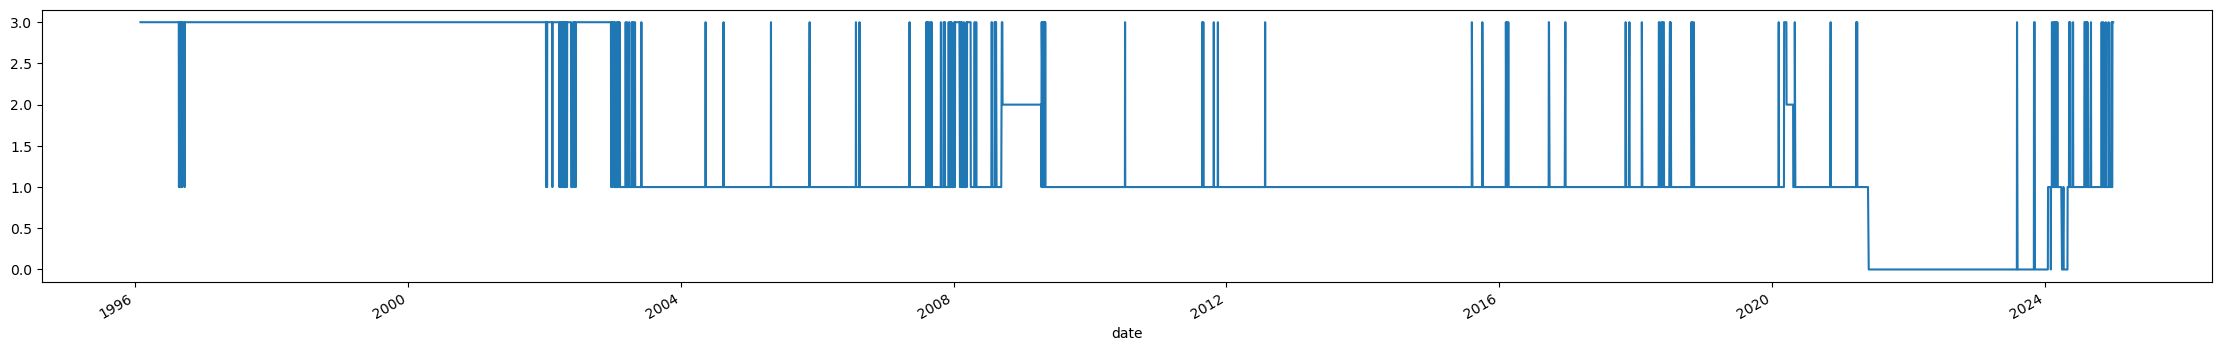

In [117]:
regime_series.plot(figsize = (28,4))

Now we will be applying regime smoothing so k-means does not flip regimes day-to-day based on PCA noise.

In [118]:
regime_series_smooth = (
    regime_series.rolling(5, center = True).apply(lambda x: x.mode()[0], raw = False))

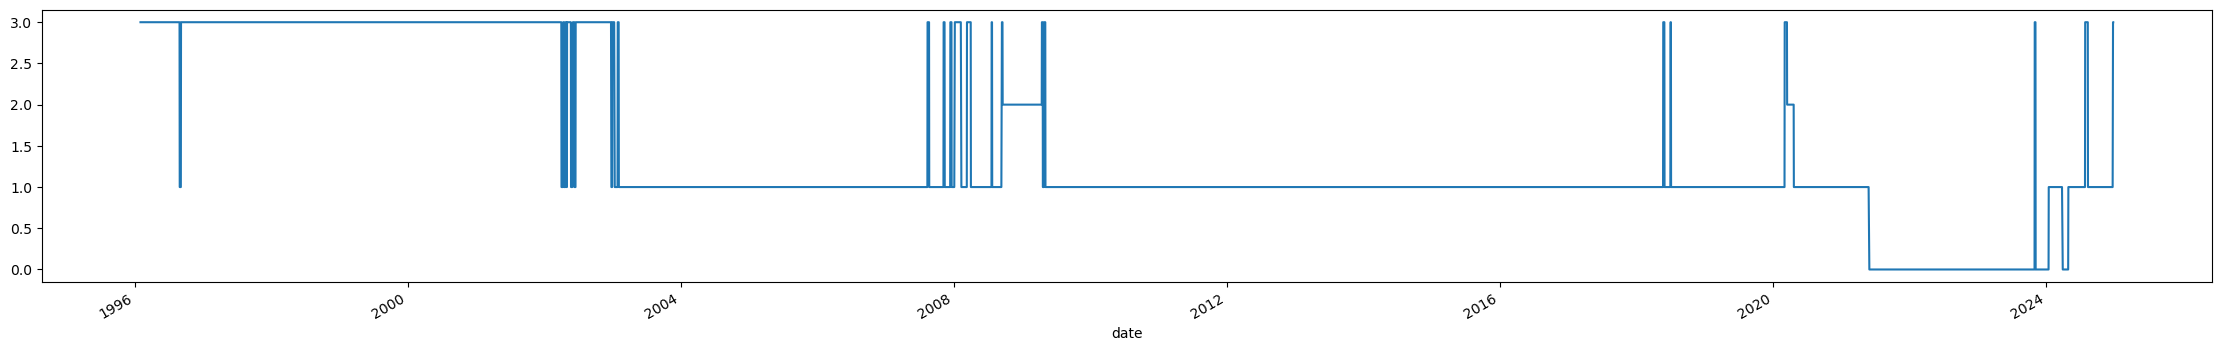

In [119]:
regime_series_smooth.plot(figsize = (28,4))
regime_series = regime_series_smooth

In [120]:
mkt_ret = return_matrix.mean(axis=1)

mkt_vol = mkt_ret.rolling(30).std()

In [121]:
dispersion = return_matrix.std(axis = 1)

In [122]:
avg_volume = volume_matrix.mean(axis=1)

In [123]:
macro_feats = pd.DataFrame({
    'CPI': macro_fred['CPIAUCSL'],
    'Term_Spread': macro_fred['DGS10'] - macro_fred['DGS2'],
    'FedFunds': macro_fred['FEDFUNDS'],
    'STLF_stress': macro_fred['STLFSI4'],
})

fx_vol = macro_duka_returns.rolling(30).std().mean(axis=1)
fx_mean = macro_duka_returns.mean(axis=1)

fingerprint_df = pd.concat([
    mkt_ret.rename('mkt_ret'),
    mkt_vol.rename('mkt_vol'),
    dispersion.rename('dispersion'),
    avg_volume.rename('avg_volume'),
    fx_vol.rename('fx_vol'),
    fx_mean.rename('fx_mean'),
    macro_feats,
    regime_series_smooth.rename('regime')
], axis=1).dropna()

regime_fingerprints = fingerprint_df.groupby('regime').agg(['mean', 'std'])
regime_fingerprints

def classify_row(row):
    if row[('mkt_vol','mean')] > fingerprint_df['mkt_vol'].mean() * 1.5:
        return "Crisis / High Vol"
    elif row[('mkt_ret','mean')] < 0:
        return "Correction / Bearish"
    elif row[('Term_Spread','mean')] < 0:
        return "Recession-like / Tightening"
    else:
        return "Expansion / Low Vol"

regime_fingerprints['Interpretation'] = regime_fingerprints.apply(classify_row, axis=1)
regime_fingerprints

mkt_ret             mkt_vol           dispersion            \
            mean       std      mean       std       mean       std   
regime                                                                
0.0    -0.000367  0.015766  0.014859  0.005441   0.023435  0.007555   
1.0     0.000476  0.012268  0.011786  0.004565   0.022962  0.008444   
2.0    -0.001574  0.038256  0.038353  0.009412   0.047389  0.013052   
3.0    -0.000181  0.020054  0.017233  0.008136   0.043857  0.012600   

          avg_volume                  fx_vol            ...   fx_mean  \
                mean           std      mean       std  ...       std   
regime                                                  ...             
0.0     5.233241e+06  1.252238e+06  0.005573  0.001497  ...  0.001697   
1.0     4.404123e+06  1.196386e+06  0.005585  0.001521  ...  0.002103   
2.0     5.900724e+06  1.416758e+06  0.013604  0.003212  ...  0.006109   
3.0     2.356360e+06  1.778521e+06  0.005671  0.001291  ...  0.002456   

               CPI            Term_Spread            FedFunds            \
              mean        std        mean       std      mean       std   
regime                                                                    
0.0     293.749038  12.372923   -0.016824  0.711487  2.680868  2.223728   
1.0     229.010412  29.127311    1.246462  0.918266  1.497523  1.747967   
2.0     219.931438  15.610825    1.711183  0.580894  0.520237  0.557489   
3.0     171.686810  19.234367    0.618671  0.742925  4.664368  1.507705   

       STLF_stress                  Interpretation  
              mean       std                        
regime                                              
0.0      -0.407102  0.364157  Correction / Bearish  
1.0      -0.179679  0.636794   Expansion / Low Vol  
2.0       5.118822  1.906610     Crisis / High Vol  
3.0       0.276086  0.543952  Correction / Bearish  

[4 rows x 21 columns]

In [137]:
final_panel['regime'] = regime_series
feature_panel_full['regime'] = regime_series
feature_panel_full.tail
import os
ARTIFACT_DIR = "/Users/dominicranelli/Desktop/BigProject/artifacts"
final_panel.to_parquet(os.path.join(ARTIFACT_DIR, "final_panel.parquet"))

ValueError: Duplicate column names found: [10104, 10107, 10182, 10299, 10302, 10401, 10657, 10876, 10890, 11081, 11154, 11403, 11504, 11533, 11825, 11896, 11936, 11997, 12085, 12308, 12490, 12546, 12570, 12742, 13008, 13009, 13046, 13168, 13169, 13210, 13323, 13379, 13407, 13447, 13511, 13628, 13949, 13963, 13964, 14136, 14295, 14393, 14504, 14542, 14593, 14702, 14714, 14926, 14939, 14944, 14970, 14984, 14988, 15315, 15579, 15707, 15850, 16140, 16309, 16382, 16595, 16649, 16753, 16932, 16968, 17278, 17341, 17685, 18267, 18420, 18421, 18484, 18485, 18726, 18734, 18886, 18909, 18911, 19084, 19403, 19654, 19788, 19794, 19818, 20117, 20204, 20648, 20894, 20917, 20972, 21004, 21413, 22206, 22293, 22425, 22779, 22921, 22976, 23063, 25022, 25559, 26084, 26403, 27684, 27705, 27828, 27983, 28847, 29209, 30648, 30681, 32046, 32054, 32205, 32540, 35916, 38543, 40125, 40483, 42796, 43123, 44506, 45911, 46077, 46886, 47466, 47677, 47941, 48020, 48144, 48291, 48486, 50286, 51369, 52813, 53065, 53189, 53197, 53480, 53613, 57808, 59328, 59432, 60169, 60206, 60599, 60871, 61146, 61241, 62260, 63125, 63706, 63773, 65875, 66093, 66384, 68320, 68857, 69526, 69593, 71685, 75069, 75104, 75153, 75180, 75422, 75510, 75603, 75607, 75654, 75754, 75828, 75831, 75854, 75912, 76076, 76185, 76201, 76226, 76230, 76422, 76584, 76624, 76752, 76795, 76829, 76846, 76947, 77118, 77173, 77178, 77338, 77357, 77392, 77418, 77534, 77624, 77918, 77971, 77976, 78084, 78148, 78172, 78179, 78955, 78975, 78987, 79059, 79094, 79108, 79265, 79530, 79564, 79628, 79678, 79698, 79794, 79839, 79879, 79903, 80012, 80049, 80185, 80192, 80266, 80329, 80366, 80791, 80924, 80957, 81121, 81162, 81256, 81282, 81501, 81539, 81599, 81650, 81696, 81850, 82274, 82521, 82598, 82643, 82686, 82746, 82759, 82762, 82834, 82924, 82932, 83291, 83399, 83405, 83413, 83419, 83621, 83630, 83669, 83734, 83779, 83946, 84165, 84168, 84176, 84342, 84372, 84418, 84519, 84624, 84761, 84769, 84827, 85035, 85274, 85518, 85522, 85576, 85631, 85753, 85963, 85991, 86047, 86077, 86144, 86158, 86200, 86211, 86298, 86308, 86401, 86580, 86822, 86881, 86926, 86964, 86979, 86994, 87030, 87092, 87167, 87184, 87299, 87378, 87390, 87401, 87445, 87612, 87815, 88180, 88182, 88264, 88360, 88439, 88618, 88795, 88992, 89305, 89393, 89525, 89565, 89641, 89659, 90215, 90319, 90374, 90441, 90442, 90455, 90550, 90655, 90699, 90805, 90806, 91041, 91063, 91136, 91611, 91668, 91883, 91937, 92020, 92257, 92293, 92497, 92765, 92778, 93002, 93132, 10104, 10107, 10182, 10299, 10302, 10401, 10657, 10876, 10890, 11081, 11154, 11403, 11504, 11533, 11825, 11896, 11936, 11997, 12085, 12308, 12490, 12546, 12570, 12742, 13008, 13009, 13046, 13168, 13169, 13210, 13323, 13379, 13407, 13447, 13511, 13628, 13949, 13963, 13964, 14136, 14295, 14393, 14504, 14542, 14593, 14702, 14714, 14926, 14939, 14944, 14970, 14984, 14988, 15315, 15579, 15707, 15850, 16140, 16309, 16382, 16595, 16649, 16753, 16932, 16968, 17278, 17341, 17685, 18267, 18420, 18421, 18484, 18485, 18726, 18734, 18886, 18909, 18911, 19084, 19403, 19654, 19788, 19794, 19818, 20117, 20204, 20648, 20894, 20917, 20972, 21004, 21413, 22206, 22293, 22425, 22779, 22921, 22976, 23063, 25022, 25559, 26084, 26403, 27684, 27705, 27828, 27983, 28847, 29209, 30648, 30681, 32046, 32054, 32205, 32540, 35916, 38543, 40125, 40483, 42796, 43123, 44506, 45911, 46077, 46886, 47466, 47677, 47941, 48020, 48144, 48291, 48486, 50286, 51369, 52813, 53065, 53189, 53197, 53480, 53613, 57808, 59328, 59432, 60169, 60206, 60599, 60871, 61146, 61241, 62260, 63125, 63706, 63773, 65875, 66093, 66384, 68320, 68857, 69526, 69593, 71685, 75069, 75104, 75153, 75180, 75422, 75510, 75603, 75607, 75654, 75754, 75828, 75831, 75854, 75912, 76076, 76185, 76201, 76226, 76230, 76422, 76584, 76624, 76752, 76795, 76829, 76846, 76947, 77118, 77173, 77178, 77338, 77357, 77392, 77418, 77534, 77624, 77918, 77971, 77976, 78084, 78148, 78172, 78179, 78955, 78975, 78987, 79059, 79094, 79108, 79265, 79530, 79564, 79628, 79678, 79698, 79794, 79839, 79879, 79903, 80012, 80049, 80185, 80192, 80266, 80329, 80366, 80791, 80924, 80957, 81121, 81162, 81256, 81282, 81501, 81539, 81599, 81650, 81696, 81850, 82274, 82521, 82598, 82643, 82686, 82746, 82759, 82762, 82834, 82924, 82932, 83291, 83399, 83405, 83413, 83419, 83621, 83630, 83669, 83734, 83779, 83946, 84165, 84168, 84176, 84342, 84372, 84418, 84519, 84624, 84761, 84769, 84827, 85035, 85274, 85518, 85522, 85576, 85631, 85753, 85963, 85991, 86047, 86077, 86144, 86158, 86200, 86211, 86298, 86308, 86401, 86580, 86822, 86881, 86926, 86964, 86979, 86994, 87030, 87092, 87167, 87184, 87299, 87378, 87390, 87401, 87445, 87612, 87815, 88180, 88182, 88264, 88360, 88439, 88618, 88795, 88992, 89305, 89393, 89525, 89565, 89641, 89659, 90215, 90319, 90374, 90441, 90442, 90455, 90550, 90655, 90699, 90805, 90806, 91041, 91063, 91136, 91611, 91668, 91883, 91937, 92020, 92257, 92293, 92497, 92765, 92778, 93002, 93132, 10104, 10107, 10182, 10299, 10302, 10401, 10657, 10876, 10890, 11081, 11154, 11403, 11504, 11533, 11825, 11896, 11936, 11997, 12085, 12308, 12490, 12546, 12570, 12742, 13008, 13009, 13046, 13168, 13169, 13210, 13323, 13379, 13407, 13447, 13511, 13628, 13949, 13963, 13964, 14136, 14295, 14393, 14504, 14542, 14593, 14702, 14714, 14926, 14939, 14944, 14970, 14984, 14988, 15315, 15579, 15707, 15850, 16140, 16309, 16382, 16595, 16649, 16753, 16932, 16968, 17278, 17341, 17685, 18267, 18420, 18421, 18484, 18485, 18726, 18734, 18886, 18909, 18911, 19084, 19403, 19654, 19788, 19794, 19818, 20117, 20204, 20648, 20894, 20917, 20972, 21004, 21413, 22206, 22293, 22425, 22779, 22921, 22976, 23063, 25022, 25559, 26084, 26403, 27684, 27705, 27828, 27983, 28847, 29209, 30648, 30681, 32046, 32054, 32205, 32540, 35916, 38543, 40125, 40483, 42796, 43123, 44506, 45911, 46077, 46886, 47466, 47677, 47941, 48020, 48144, 48291, 48486, 50286, 51369, 52813, 53065, 53189, 53197, 53480, 53613, 57808, 59328, 59432, 60169, 60206, 60599, 60871, 61146, 61241, 62260, 63125, 63706, 63773, 65875, 66093, 66384, 68320, 68857, 69526, 69593, 71685, 75069, 75104, 75153, 75180, 75422, 75510, 75603, 75607, 75654, 75754, 75828, 75831, 75854, 75912, 76076, 76185, 76201, 76226, 76230, 76422, 76584, 76624, 76752, 76795, 76829, 76846, 76947, 77118, 77173, 77178, 77338, 77357, 77392, 77418, 77534, 77624, 77918, 77971, 77976, 78084, 78148, 78172, 78179, 78955, 78975, 78987, 79059, 79094, 79108, 79265, 79530, 79564, 79628, 79678, 79698, 79794, 79839, 79879, 79903, 80012, 80049, 80185, 80192, 80266, 80329, 80366, 80791, 80924, 80957, 81121, 81162, 81256, 81282, 81501, 81539, 81599, 81650, 81696, 81850, 82274, 82521, 82598, 82643, 82686, 82746, 82759, 82762, 82834, 82924, 82932, 83291, 83399, 83405, 83413, 83419, 83621, 83630, 83669, 83734, 83779, 83946, 84165, 84168, 84176, 84342, 84372, 84418, 84519, 84624, 84761, 84769, 84827, 85035, 85274, 85518, 85522, 85576, 85631, 85753, 85963, 85991, 86047, 86077, 86144, 86158, 86200, 86211, 86298, 86308, 86401, 86580, 86822, 86881, 86926, 86964, 86979, 86994, 87030, 87092, 87167, 87184, 87299, 87378, 87390, 87401, 87445, 87612, 87815, 88180, 88182, 88264, 88360, 88439, 88618, 88795, 88992, 89305, 89393, 89525, 89565, 89641, 89659, 90215, 90319, 90374, 90441, 90442, 90455, 90550, 90655, 90699, 90805, 90806, 91041, 91063, 91136, 91611, 91668, 91883, 91937, 92020, 92257, 92293, 92497, 92765, 92778, 93002, 93132, 'CPIAUCSL', 'CPILFESL', 'DGS2', 'DGS10', 'DTB3', 'FEDFUNDS', 'STLFSI4', 'UNRATE', 'CADUSDReturns', 'CHFUSDReturns', 'JPYUSDReturns', 'AUDUSDReturns', 'GBPUSDReturns', ('atq', 10104), ('atq', 10107), ('atq', 10182), ('atq', 10299), ('atq', 10302), ('atq', 10657), ('atq', 10890), ('atq', 11081), ('atq', 11154), ('atq', 11403), ('atq', 11533), ('atq', 11825), ('atq', 11896), ('atq', 12308), ('atq', 12490), ('atq', 12546), ('atq', 12742), ('atq', 13008), ('atq', 13046), ('atq', 13168), ('atq', 13169), ('atq', 13210), ('atq', 13323), ('atq', 13379), ('atq', 13447), ('atq', 13511), ('atq', 13628), ('atq', 13949), ('atq', 13963), ('atq', 14136), ('atq', 14295), ('atq', 14593), ('atq', 14702), ('atq', 14714), ('atq', 14926), ('atq', 14970), ('atq', 14984), ('atq', 14988), ('atq', 15315), ('atq', 15579), ('atq', 15707), ('atq', 15850), ('atq', 16140), ('atq', 16309), ('atq', 16382), ('atq', 16595), ('atq', 16649), ('atq', 16753), ('atq', 16932), ('atq', 16968), ('atq', 17341), ('atq', 17685), ('atq', 18420), ('atq', 18484), ('atq', 18485), ('atq', 18726), ('atq', 18911), ('atq', 19084), ('atq', 19654), ('atq', 19788), ('atq', 20117), ('atq', 20648), ('atq', 22206), ('atq', 22293), ('atq', 22779), ('atq', 22921), ('atq', 26084), ('atq', 26403), ('atq', 27684), ('atq', 27705), ('atq', 27828), ('atq', 27983), ('atq', 28847), ('atq', 29209), ('atq', 30648), ('atq', 30681), ('atq', 32046), ('atq', 32054), ('atq', 32540), ('atq', 40125), ('atq', 42796), ('atq', 44506), ('atq', 45911), ('atq', 46077), ('atq', 46886), ('atq', 47466), ('atq', 47677), ('atq', 47941), ('atq', 48144), ('atq', 48291), ('atq', 48486), ('atq', 50286), ('atq', 51369), ('atq', 52813), ('atq', 53065), ('atq', 53197), ('atq', 53480), ('atq', 53613), ('atq', 57808), ('atq', 59328), ('atq', 60599), ('atq', 60871), ('atq', 61146), ('atq', 61241), ('atq', 63125), ('atq', 63706), ('atq', 63773), ('atq', 65875), ('atq', 66093), ('atq', 66384), ('atq', 68320), ('atq', 75069), ('atq', 75510), ('atq', 75603), ('atq', 75654), ('atq', 75828), ('atq', 75831), ('atq', 75854), ('atq', 76076), ('atq', 76185), ('atq', 76201), ('atq', 76230), ('atq', 76584), ('atq', 76624), ('atq', 76752), ('atq', 76795), ('atq', 76846), ('atq', 76947), ('atq', 77173), ('atq', 77178), ('atq', 77338), ('atq', 77357), ('atq', 77418), ('atq', 77624), ('atq', 77918), ('atq', 77971), ('atq', 78084), ('atq', 78172), ('atq', 78179), ('atq', 78955), ('atq', 78975), ('atq', 78987), ('atq', 79094), ('atq', 79108), ('atq', 79265), ('atq', 79564), ('atq', 79628), ('atq', 79678), ('atq', 79698), ('atq', 79839), ('atq', 79879), ('atq', 79903), ('atq', 80012), ('atq', 80049), ('atq', 80266), ('atq', 80329), ('atq', 80791), ('atq', 80924), ('atq', 80957), ('atq', 81121), ('atq', 81162), ('atq', 81256), ('atq', 81282), ('atq', 81501), ('atq', 81539), ('atq', 81650), ('atq', 81696), ('atq', 81850), ('atq', 82274), ('atq', 82521), ('atq', 82598), ('atq', 82643), ('atq', 82686), ('atq', 82759), ('atq', 82762), ('atq', 82924), ('atq', 83291), ('atq', 83399), ('atq', 83405), ('atq', 83413), ('atq', 83621), ('atq', 83630), ('atq', 83669), ('atq', 83779), ('atq', 84165), ('atq', 84168), ('atq', 84176), ('atq', 84342), ('atq', 84372), ('atq', 84519), ('atq', 84761), ('atq', 84769), ('atq', 84827), ('atq', 85035), ('atq', 85518), ('atq', 85522), ('atq', 85576), ('atq', 85631), ('atq', 85753), ('atq', 85963), ('atq', 85991), ('atq', 86047), ('atq', 86144), ('atq', 86158), ('atq', 86200), ('atq', 86211), ('atq', 86308), ('atq', 86580), ('atq', 86822), ('atq', 86881), ('atq', 86926), ('atq', 86964), ('atq', 86979), ('atq', 87092), ('atq', 87167), ('atq', 87184), ('atq', 87299), ('atq', 87390), ('atq', 87445), ('atq', 87612), ('atq', 88182), ('atq', 88264), ('atq', 88360), ('atq', 88439), ('atq', 88795), ('atq', 89305), ('atq', 89393), ('atq', 89525), ('atq', 89641), ('atq', 89659), ('atq', 90215), ('atq', 90319), ('atq', 90374), ('atq', 90441), ('atq', 90455), ('atq', 90550), ('atq', 90699), ('atq', 91041), ('atq', 91063), ('atq', 91136), ('atq', 91611), ('atq', 91668), ('atq', 91883), ('atq', 91937), ('atq', 92020), ('atq', 92257), ('atq', 92293), ('atq', 92765), ('atq', 93002), ('atq', 93132), ('revtq', 10104), ('revtq', 10107), ('revtq', 10182), ('revtq', 10299), ('revtq', 10302), ('revtq', 10657), ('revtq', 10890), ('revtq', 11081), ('revtq', 11154), ('revtq', 11403), ('revtq', 11533), ('revtq', 11825), ('revtq', 11896), ('revtq', 12308), ('revtq', 12490), ('revtq', 12546), ('revtq', 12742), ('revtq', 13008), ('revtq', 13046), ('revtq', 13168), ('revtq', 13169), ('revtq', 13210), ('revtq', 13323), ('revtq', 13379), ('revtq', 13447), ('revtq', 13511), ('revtq', 13628), ('revtq', 13949), ('revtq', 13963), ('revtq', 14136), ('revtq', 14295), ('revtq', 14593), ('revtq', 14702), ('revtq', 14714), ('revtq', 14926), ('revtq', 14970), ('revtq', 14984), ('revtq', 14988), ('revtq', 15315), ('revtq', 15579), ('revtq', 15707), ('revtq', 15850), ('revtq', 16140), ('revtq', 16309), ('revtq', 16382), ('revtq', 16595), ('revtq', 16649), ('revtq', 16753), ('revtq', 16932), ('revtq', 16968), ('revtq', 17341), ('revtq', 17685), ('revtq', 18420), ('revtq', 18484), ('revtq', 18485), ('revtq', 18726), ('revtq', 18911), ('revtq', 19084), ('revtq', 19654), ('revtq', 19788), ('revtq', 20117), ('revtq', 20648), ('revtq', 22206), ('revtq', 22293), ('revtq', 22779), ('revtq', 22921), ('revtq', 26084), ('revtq', 26403), ('revtq', 27684), ('revtq', 27705), ('revtq', 27828), ('revtq', 27983), ('revtq', 28847), ('revtq', 29209), ('revtq', 30648), ('revtq', 30681), ('revtq', 32046), ('revtq', 32054), ('revtq', 32540), ('revtq', 40125), ('revtq', 42796), ('revtq', 44506), ('revtq', 45911), ('revtq', 46077), ('revtq', 46886), ('revtq', 47466), ('revtq', 47677), ('revtq', 47941), ('revtq', 48144), ('revtq', 48291), ('revtq', 48486), ('revtq', 50286), ('revtq', 51369), ('revtq', 52813), ('revtq', 53065), ('revtq', 53197), ('revtq', 53480), ('revtq', 53613), ('revtq', 57808), ('revtq', 59328), ('revtq', 60599), ('revtq', 60871), ('revtq', 61146), ('revtq', 61241), ('revtq', 63125), ('revtq', 63706), ('revtq', 63773), ('revtq', 65875), ('revtq', 66093), ('revtq', 66384), ('revtq', 68320), ('revtq', 75069), ('revtq', 75510), ('revtq', 75603), ('revtq', 75654), ('revtq', 75828), ('revtq', 75831), ('revtq', 75854), ('revtq', 76076), ('revtq', 76185), ('revtq', 76201), ('revtq', 76230), ('revtq', 76584), ('revtq', 76624), ('revtq', 76752), ('revtq', 76795), ('revtq', 76846), ('revtq', 76947), ('revtq', 77173), ('revtq', 77178), ('revtq', 77338), ('revtq', 77357), ('revtq', 77418), ('revtq', 77624), ('revtq', 77918), ('revtq', 77971), ('revtq', 78084), ('revtq', 78172), ('revtq', 78179), ('revtq', 78955), ('revtq', 78975), ('revtq', 78987), ('revtq', 79094), ('revtq', 79108), ('revtq', 79265), ('revtq', 79564), ('revtq', 79628), ('revtq', 79678), ('revtq', 79698), ('revtq', 79839), ('revtq', 79879), ('revtq', 79903), ('revtq', 80012), ('revtq', 80049), ('revtq', 80266), ('revtq', 80329), ('revtq', 80791), ('revtq', 80924), ('revtq', 80957), ('revtq', 81121), ('revtq', 81162), ('revtq', 81256), ('revtq', 81282), ('revtq', 81501), ('revtq', 81539), ('revtq', 81650), ('revtq', 81696), ('revtq', 81850), ('revtq', 82274), ('revtq', 82521), ('revtq', 82598), ('revtq', 82643), ('revtq', 82686), ('revtq', 82759), ('revtq', 82762), ('revtq', 82924), ('revtq', 83291), ('revtq', 83399), ('revtq', 83405), ('revtq', 83413), ('revtq', 83621), ('revtq', 83630), ('revtq', 83669), ('revtq', 83779), ('revtq', 84165), ('revtq', 84168), ('revtq', 84176), ('revtq', 84342), ('revtq', 84372), ('revtq', 84519), ('revtq', 84761), ('revtq', 84769), ('revtq', 84827), ('revtq', 85035), ('revtq', 85518), ('revtq', 85522), ('revtq', 85576), ('revtq', 85631), ('revtq', 85753), ('revtq', 85963), ('revtq', 85991), ('revtq', 86047), ('revtq', 86144), ('revtq', 86158), ('revtq', 86200), ('revtq', 86211), ('revtq', 86308), ('revtq', 86580), ('revtq', 86822), ('revtq', 86881), ('revtq', 86926), ('revtq', 86964), ('revtq', 86979), ('revtq', 87092), ('revtq', 87167), ('revtq', 87184), ('revtq', 87299), ('revtq', 87390), ('revtq', 87445), ('revtq', 87612), ('revtq', 88182), ('revtq', 88264), ('revtq', 88360), ('revtq', 88439), ('revtq', 88795), ('revtq', 89305), ('revtq', 89393), ('revtq', 89525), ('revtq', 89641), ('revtq', 89659), ('revtq', 90215), ('revtq', 90319), ('revtq', 90374), ('revtq', 90441), ('revtq', 90455), ('revtq', 90550), ('revtq', 90699), ('revtq', 91041), ('revtq', 91063), ('revtq', 91136), ('revtq', 91611), ('revtq', 91668), ('revtq', 91883), ('revtq', 91937), ('revtq', 92020), ('revtq', 92257), ('revtq', 92293), ('revtq', 92765), ('revtq', 93002), ('revtq', 93132), ('niq', 10104), ('niq', 10107), ('niq', 10182), ('niq', 10299), ('niq', 10302), ('niq', 10657), ('niq', 10890), ('niq', 11081), ('niq', 11154), ('niq', 11403), ('niq', 11533), ('niq', 11825), ('niq', 11896), ('niq', 12308), ('niq', 12490), ('niq', 12546), ('niq', 12742), ('niq', 13008), ('niq', 13046), ('niq', 13168), ('niq', 13169), ('niq', 13210), ('niq', 13323), ('niq', 13379), ('niq', 13447), ('niq', 13511), ('niq', 13628), ('niq', 13949), ('niq', 13963), ('niq', 14136), ('niq', 14295), ('niq', 14593), ('niq', 14702), ('niq', 14714), ('niq', 14926), ('niq', 14970), ('niq', 14984), ('niq', 14988), ('niq', 15315), ('niq', 15579), ('niq', 15707), ('niq', 15850), ('niq', 16140), ('niq', 16309), ('niq', 16382), ('niq', 16595), ('niq', 16649), ('niq', 16753), ('niq', 16932), ('niq', 16968), ('niq', 17341), ('niq', 17685), ('niq', 18420), ('niq', 18484), ('niq', 18485), ('niq', 18726), ('niq', 18911), ('niq', 19084), ('niq', 19654), ('niq', 19788), ('niq', 20117), ('niq', 20648), ('niq', 22206), ('niq', 22293), ('niq', 22779), ('niq', 22921), ('niq', 26084), ('niq', 26403), ('niq', 27684), ('niq', 27705), ('niq', 27828), ('niq', 27983), ('niq', 28847), ('niq', 29209), ('niq', 30648), ('niq', 30681), ('niq', 32046), ('niq', 32054), ('niq', 32540), ('niq', 40125), ('niq', 42796), ('niq', 44506), ('niq', 45911), ('niq', 46077), ('niq', 46886), ('niq', 47466), ('niq', 47677), ('niq', 47941), ('niq', 48144), ('niq', 48291), ('niq', 48486), ('niq', 50286), ('niq', 51369), ('niq', 52813), ('niq', 53065), ('niq', 53197), ('niq', 53480), ('niq', 53613), ('niq', 57808), ('niq', 59328), ('niq', 60599), ('niq', 60871), ('niq', 61146), ('niq', 61241), ('niq', 63125), ('niq', 63706), ('niq', 63773), ('niq', 65875), ('niq', 66093), ('niq', 66384), ('niq', 68320), ('niq', 75069), ('niq', 75510), ('niq', 75603), ('niq', 75654), ('niq', 75828), ('niq', 75831), ('niq', 75854), ('niq', 76076), ('niq', 76185), ('niq', 76201), ('niq', 76230), ('niq', 76584), ('niq', 76624), ('niq', 76752), ('niq', 76795), ('niq', 76846), ('niq', 76947), ('niq', 77173), ('niq', 77178), ('niq', 77338), ('niq', 77357), ('niq', 77418), ('niq', 77624), ('niq', 77918), ('niq', 77971), ('niq', 78084), ('niq', 78172), ('niq', 78179), ('niq', 78955), ('niq', 78975), ('niq', 78987), ('niq', 79094), ('niq', 79108), ('niq', 79265), ('niq', 79564), ('niq', 79628), ('niq', 79678), ('niq', 79698), ('niq', 79839), ('niq', 79879), ('niq', 79903), ('niq', 80012), ('niq', 80049), ('niq', 80266), ('niq', 80329), ('niq', 80791), ('niq', 80924), ('niq', 80957), ('niq', 81121), ('niq', 81162), ('niq', 81256), ('niq', 81282), ('niq', 81501), ('niq', 81539), ('niq', 81650), ('niq', 81696), ('niq', 81850), ('niq', 82274), ('niq', 82521), ('niq', 82598), ('niq', 82643), ('niq', 82686), ('niq', 82759), ('niq', 82762), ('niq', 82924), ('niq', 83291), ('niq', 83399), ('niq', 83405), ('niq', 83413), ('niq', 83621), ('niq', 83630), ('niq', 83669), ('niq', 83779), ('niq', 84165), ('niq', 84168), ('niq', 84176), ('niq', 84342), ('niq', 84372), ('niq', 84519), ('niq', 84761), ('niq', 84769), ('niq', 84827), ('niq', 85035), ('niq', 85518), ('niq', 85522), ('niq', 85576), ('niq', 85631), ('niq', 85753), ('niq', 85963), ('niq', 85991), ('niq', 86047), ('niq', 86144), ('niq', 86158), ('niq', 86200), ('niq', 86211), ('niq', 86308), ('niq', 86580), ('niq', 86822), ('niq', 86881), ('niq', 86926), ('niq', 86964), ('niq', 86979), ('niq', 87092), ('niq', 87167), ('niq', 87184), ('niq', 87299), ('niq', 87390), ('niq', 87445), ('niq', 87612), ('niq', 88182), ('niq', 88264), ('niq', 88360), ('niq', 88439), ('niq', 88795), ('niq', 89305), ('niq', 89393), ('niq', 89525), ('niq', 89641), ('niq', 89659), ('niq', 90215), ('niq', 90319), ('niq', 90374), ('niq', 90441), ('niq', 90455), ('niq', 90550), ('niq', 90699), ('niq', 91041), ('niq', 91063), ('niq', 91136), ('niq', 91611), ('niq', 91668), ('niq', 91883), ('niq', 91937), ('niq', 92020), ('niq', 92257), ('niq', 92293), ('niq', 92765), ('niq', 93002), ('niq', 93132), ('ceqq', 10104), ('ceqq', 10107), ('ceqq', 10182), ('ceqq', 10299), ('ceqq', 10302), ('ceqq', 10657), ('ceqq', 10890), ('ceqq', 11081), ('ceqq', 11154), ('ceqq', 11403), ('ceqq', 11533), ('ceqq', 11825), ('ceqq', 11896), ('ceqq', 12308), ('ceqq', 12490), ('ceqq', 12546), ('ceqq', 12742), ('ceqq', 13008), ('ceqq', 13046), ('ceqq', 13168), ('ceqq', 13169), ('ceqq', 13210), ('ceqq', 13323), ('ceqq', 13379), ('ceqq', 13447), ('ceqq', 13511), ('ceqq', 13628), ('ceqq', 13949), ('ceqq', 13963), ('ceqq', 14136), ('ceqq', 14295), ('ceqq', 14593), ('ceqq', 14702), ('ceqq', 14714), ('ceqq', 14926), ('ceqq', 14970), ('ceqq', 14984), ('ceqq', 14988), ('ceqq', 15315), ('ceqq', 15579), ('ceqq', 15707), ('ceqq', 15850), ('ceqq', 16140), ('ceqq', 16309), ('ceqq', 16382), ('ceqq', 16595), ('ceqq', 16649), ('ceqq', 16753), ('ceqq', 16932), ('ceqq', 16968), ('ceqq', 17341), ('ceqq', 17685), ('ceqq', 18420), ('ceqq', 18484), ('ceqq', 18485), ('ceqq', 18726), ('ceqq', 18911), ('ceqq', 19084), ('ceqq', 19654), ('ceqq', 19788), ('ceqq', 20117), ('ceqq', 20648), ('ceqq', 22206), ('ceqq', 22293), ('ceqq', 22779), ('ceqq', 22921), ('ceqq', 26084), ('ceqq', 26403), ('ceqq', 27684), ('ceqq', 27705), ('ceqq', 27828), ('ceqq', 27983), ('ceqq', 28847), ('ceqq', 29209), ('ceqq', 30648), ('ceqq', 30681), ('ceqq', 32046), ('ceqq', 32054), ('ceqq', 32540), ('ceqq', 40125), ('ceqq', 42796), ('ceqq', 44506), ('ceqq', 45911), ('ceqq', 46077), ('ceqq', 46886), ('ceqq', 47466), ('ceqq', 47677), ('ceqq', 47941), ('ceqq', 48144), ('ceqq', 48291), ('ceqq', 48486), ('ceqq', 50286), ('ceqq', 51369), ('ceqq', 52813), ('ceqq', 53065), ('ceqq', 53197), ('ceqq', 53480), ('ceqq', 53613), ('ceqq', 57808), ('ceqq', 59328), ('ceqq', 60599), ('ceqq', 60871), ('ceqq', 61146), ('ceqq', 61241), ('ceqq', 63125), ('ceqq', 63706), ('ceqq', 63773), ('ceqq', 65875), ('ceqq', 66093), ('ceqq', 66384), ('ceqq', 68320), ('ceqq', 75069), ('ceqq', 75510), ('ceqq', 75603), ('ceqq', 75654), ('ceqq', 75828), ('ceqq', 75831), ('ceqq', 75854), ('ceqq', 76076), ('ceqq', 76185), ('ceqq', 76201), ('ceqq', 76230), ('ceqq', 76584), ('ceqq', 76624), ('ceqq', 76752), ('ceqq', 76795), ('ceqq', 76846), ('ceqq', 76947), ('ceqq', 77173), ('ceqq', 77178), ('ceqq', 77338), ('ceqq', 77357), ('ceqq', 77418), ('ceqq', 77624), ('ceqq', 77918), ('ceqq', 77971), ('ceqq', 78084), ('ceqq', 78172), ('ceqq', 78179), ('ceqq', 78955), ('ceqq', 78975), ('ceqq', 78987), ('ceqq', 79094), ('ceqq', 79108), ('ceqq', 79265), ('ceqq', 79564), ('ceqq', 79628), ('ceqq', 79678), ('ceqq', 79698), ('ceqq', 79839), ('ceqq', 79879), ('ceqq', 79903), ('ceqq', 80012), ('ceqq', 80049), ('ceqq', 80266), ('ceqq', 80329), ('ceqq', 80791), ('ceqq', 80924), ('ceqq', 80957), ('ceqq', 81121), ('ceqq', 81162), ('ceqq', 81256), ('ceqq', 81282), ('ceqq', 81501), ('ceqq', 81539), ('ceqq', 81650), ('ceqq', 81696), ('ceqq', 81850), ('ceqq', 82274), ('ceqq', 82521), ('ceqq', 82598), ('ceqq', 82643), ('ceqq', 82686), ('ceqq', 82759), ('ceqq', 82762), ('ceqq', 82924), ('ceqq', 83291), ('ceqq', 83399), ('ceqq', 83405), ('ceqq', 83413), ('ceqq', 83621), ('ceqq', 83630), ('ceqq', 83669), ('ceqq', 83779), ('ceqq', 84165), ('ceqq', 84168), ('ceqq', 84176), ('ceqq', 84342), ('ceqq', 84372), ('ceqq', 84519), ('ceqq', 84761), ('ceqq', 84769), ('ceqq', 84827), ('ceqq', 85035), ('ceqq', 85518), ('ceqq', 85522), ('ceqq', 85576), ('ceqq', 85631), ('ceqq', 85753), ('ceqq', 85963), ('ceqq', 85991), ('ceqq', 86047), ('ceqq', 86144), ('ceqq', 86158), ('ceqq', 86200), ('ceqq', 86211), ('ceqq', 86308), ('ceqq', 86580), ('ceqq', 86822), ('ceqq', 86881), ('ceqq', 86926), ('ceqq', 86964), ('ceqq', 86979), ('ceqq', 87092), ('ceqq', 87167), ('ceqq', 87184), ('ceqq', 87299), ('ceqq', 87390), ('ceqq', 87445), ('ceqq', 87612), ('ceqq', 88182), ('ceqq', 88264), ('ceqq', 88360), ('ceqq', 88439), ('ceqq', 88795), ('ceqq', 89305), ('ceqq', 89393), ('ceqq', 89525), ('ceqq', 89641), ('ceqq', 89659), ('ceqq', 90215), ('ceqq', 90319), ('ceqq', 90374), ('ceqq', 90441), ('ceqq', 90455), ('ceqq', 90550), ('ceqq', 90699), ('ceqq', 91041), ('ceqq', 91063), ('ceqq', 91136), ('ceqq', 91611), ('ceqq', 91668), ('ceqq', 91883), ('ceqq', 91937), ('ceqq', 92020), ('ceqq', 92257), ('ceqq', 92293), ('ceqq', 92765), ('ceqq', 93002), ('ceqq', 93132), ('ltq', 10104), ('ltq', 10107), ('ltq', 10182), ('ltq', 10299), ('ltq', 10302), ('ltq', 10657), ('ltq', 10890), ('ltq', 11081), ('ltq', 11154), ('ltq', 11403), ('ltq', 11533), ('ltq', 11825), ('ltq', 11896), ('ltq', 12308), ('ltq', 12490), ('ltq', 12546), ('ltq', 12742), ('ltq', 13008), ('ltq', 13046), ('ltq', 13168), ('ltq', 13169), ('ltq', 13210), ('ltq', 13323), ('ltq', 13379), ('ltq', 13447), ('ltq', 13511), ('ltq', 13628), ('ltq', 13949), ('ltq', 13963), ('ltq', 14136), ('ltq', 14295), ('ltq', 14593), ('ltq', 14702), ('ltq', 14714), ('ltq', 14926), ('ltq', 14970), ('ltq', 14984), ('ltq', 14988), ('ltq', 15315), ('ltq', 15579), ('ltq', 15707), ('ltq', 15850), ('ltq', 16140), ('ltq', 16309), ('ltq', 16382), ('ltq', 16595), ('ltq', 16649), ('ltq', 16753), ('ltq', 16932), ('ltq', 16968), ('ltq', 17341), ('ltq', 17685), ('ltq', 18420), ('ltq', 18484), ('ltq', 18485), ('ltq', 18726), ('ltq', 18911), ('ltq', 19084), ('ltq', 19654), ('ltq', 19788), ('ltq', 20117), ('ltq', 20648), ('ltq', 22206), ('ltq', 22293), ('ltq', 22779), ('ltq', 22921), ('ltq', 26084), ('ltq', 26403), ('ltq', 27684), ('ltq', 27705), ('ltq', 27828), ('ltq', 27983), ('ltq', 28847), ('ltq', 29209), ('ltq', 30648), ('ltq', 30681), ('ltq', 32046), ('ltq', 32054), ('ltq', 32540), ('ltq', 40125), ('ltq', 42796), ('ltq', 44506), ('ltq', 45911), ('ltq', 46077), ('ltq', 46886), ('ltq', 47466), ('ltq', 47677), ('ltq', 47941), ('ltq', 48144), ('ltq', 48291), ('ltq', 48486), ('ltq', 50286), ('ltq', 51369), ('ltq', 52813), ('ltq', 53065), ('ltq', 53197), ('ltq', 53480), ('ltq', 53613), ('ltq', 57808), ('ltq', 59328), ('ltq', 60599), ('ltq', 60871), ('ltq', 61146), ('ltq', 61241), ('ltq', 63125), ('ltq', 63706), ('ltq', 63773), ('ltq', 65875), ('ltq', 66093), ('ltq', 66384), ('ltq', 68320), ('ltq', 75069), ('ltq', 75510), ('ltq', 75603), ('ltq', 75654), ('ltq', 75828), ('ltq', 75831), ('ltq', 75854), ('ltq', 76076), ('ltq', 76185), ('ltq', 76201), ('ltq', 76230), ('ltq', 76584), ('ltq', 76624), ('ltq', 76752), ('ltq', 76795), ('ltq', 76846), ('ltq', 76947), ('ltq', 77173), ('ltq', 77178), ('ltq', 77338), ('ltq', 77357), ('ltq', 77418), ('ltq', 77624), ('ltq', 77918), ('ltq', 77971), ('ltq', 78084), ('ltq', 78172), ('ltq', 78179), ('ltq', 78955), ('ltq', 78975), ('ltq', 78987), ('ltq', 79094), ('ltq', 79108), ('ltq', 79265), ('ltq', 79564), ('ltq', 79628), ('ltq', 79678), ('ltq', 79698), ('ltq', 79839), ('ltq', 79879), ('ltq', 79903), ('ltq', 80012), ('ltq', 80049), ('ltq', 80266), ('ltq', 80329), ('ltq', 80791), ('ltq', 80924), ('ltq', 80957), ('ltq', 81121), ('ltq', 81162), ('ltq', 81256), ('ltq', 81282), ('ltq', 81501), ('ltq', 81539), ('ltq', 81650), ('ltq', 81696), ('ltq', 81850), ('ltq', 82274), ('ltq', 82521), ('ltq', 82598), ('ltq', 82643), ('ltq', 82686), ('ltq', 82759), ('ltq', 82762), ('ltq', 82924), ('ltq', 83291), ('ltq', 83399), ('ltq', 83405), ('ltq', 83413), ('ltq', 83621), ('ltq', 83630), ('ltq', 83669), ('ltq', 83779), ('ltq', 84165), ('ltq', 84168), ('ltq', 84176), ('ltq', 84342), ('ltq', 84372), ('ltq', 84519), ('ltq', 84761), ('ltq', 84769), ('ltq', 84827), ('ltq', 85035), ('ltq', 85518), ('ltq', 85522), ('ltq', 85576), ('ltq', 85631), ('ltq', 85753), ('ltq', 85963), ('ltq', 85991), ('ltq', 86047), ('ltq', 86144), ('ltq', 86158), ('ltq', 86200), ('ltq', 86211), ('ltq', 86308), ('ltq', 86580), ('ltq', 86822), ('ltq', 86881), ('ltq', 86926), ('ltq', 86964), ('ltq', 86979), ('ltq', 87092), ('ltq', 87167), ('ltq', 87184), ('ltq', 87299), ('ltq', 87390), ('ltq', 87445), ('ltq', 87612), ('ltq', 88182), ('ltq', 88264), ('ltq', 88360), ('ltq', 88439), ('ltq', 88795), ('ltq', 89305), ('ltq', 89393), ('ltq', 89525), ('ltq', 89641), ('ltq', 89659), ('ltq', 90215), ('ltq', 90319), ('ltq', 90374), ('ltq', 90441), ('ltq', 90455), ('ltq', 90550), ('ltq', 90699), ('ltq', 91041), ('ltq', 91063), ('ltq', 91136), ('ltq', 91611), ('ltq', 91668), ('ltq', 91883), ('ltq', 91937), ('ltq', 92020), ('ltq', 92257), ('ltq', 92293), ('ltq', 92765), ('ltq', 93002), ('ltq', 93132), ('capxy', 10104), ('capxy', 10107), ('capxy', 10182), ('capxy', 10299), ('capxy', 10302), ('capxy', 10657), ('capxy', 10890), ('capxy', 11081), ('capxy', 11154), ('capxy', 11403), ('capxy', 11533), ('capxy', 11825), ('capxy', 11896), ('capxy', 12308), ('capxy', 12490), ('capxy', 12546), ('capxy', 12742), ('capxy', 13008), ('capxy', 13046), ('capxy', 13168), ('capxy', 13169), ('capxy', 13210), ('capxy', 13323), ('capxy', 13379), ('capxy', 13447), ('capxy', 13511), ('capxy', 13628), ('capxy', 13949), ('capxy', 13963), ('capxy', 14136), ('capxy', 14295), ('capxy', 14593), ('capxy', 14702), ('capxy', 14714), ('capxy', 14926), ('capxy', 14970), ('capxy', 14984), ('capxy', 14988), ('capxy', 15315), ('capxy', 15579), ('capxy', 15707), ('capxy', 15850), ('capxy', 16140), ('capxy', 16309), ('capxy', 16382), ('capxy', 16595), ('capxy', 16649), ('capxy', 16753), ('capxy', 16932), ('capxy', 16968), ('capxy', 17341), ('capxy', 17685), ('capxy', 18420), ('capxy', 18484), ('capxy', 18485), ('capxy', 18726), ('capxy', 18911), ('capxy', 19084), ('capxy', 19654), ('capxy', 19788), ('capxy', 20117), ('capxy', 20648), ('capxy', 22206), ('capxy', 22293), ('capxy', 22779), ('capxy', 22921), ('capxy', 26084), ('capxy', 26403), ('capxy', 27684), ('capxy', 27705), ('capxy', 27828), ('capxy', 27983), ('capxy', 28847), ('capxy', 29209), ('capxy', 30648), ('capxy', 30681), ('capxy', 32046), ('capxy', 32054), ('capxy', 32540), ('capxy', 40125), ('capxy', 42796), ('capxy', 44506), ('capxy', 45911), ('capxy', 46077), ('capxy', 46886), ('capxy', 47466), ('capxy', 47677), ('capxy', 47941), ('capxy', 48144), ('capxy', 48291), ('capxy', 48486), ('capxy', 50286), ('capxy', 51369), ('capxy', 52813), ('capxy', 53065), ('capxy', 53197), ('capxy', 53480), ('capxy', 53613), ('capxy', 57808), ('capxy', 59328), ('capxy', 60599), ('capxy', 60871), ('capxy', 61146), ('capxy', 61241), ('capxy', 63125), ('capxy', 63706), ('capxy', 63773), ('capxy', 65875), ('capxy', 66093), ('capxy', 66384), ('capxy', 68320), ('capxy', 75069), ('capxy', 75510), ('capxy', 75603), ('capxy', 75654), ('capxy', 75828), ('capxy', 75831), ('capxy', 75854), ('capxy', 76076), ('capxy', 76185), ('capxy', 76201), ('capxy', 76230), ('capxy', 76584), ('capxy', 76624), ('capxy', 76752), ('capxy', 76795), ('capxy', 76846), ('capxy', 76947), ('capxy', 77173), ('capxy', 77178), ('capxy', 77338), ('capxy', 77357), ('capxy', 77418), ('capxy', 77624), ('capxy', 77918), ('capxy', 77971), ('capxy', 78084), ('capxy', 78172), ('capxy', 78179), ('capxy', 78955), ('capxy', 78975), ('capxy', 78987), ('capxy', 79094), ('capxy', 79108), ('capxy', 79265), ('capxy', 79564), ('capxy', 79628), ('capxy', 79678), ('capxy', 79698), ('capxy', 79839), ('capxy', 79879), ('capxy', 79903), ('capxy', 80012), ('capxy', 80049), ('capxy', 80266), ('capxy', 80329), ('capxy', 80791), ('capxy', 80924), ('capxy', 80957), ('capxy', 81121), ('capxy', 81162), ('capxy', 81256), ('capxy', 81282), ('capxy', 81501), ('capxy', 81539), ('capxy', 81650), ('capxy', 81696), ('capxy', 81850), ('capxy', 82274), ('capxy', 82521), ('capxy', 82598), ('capxy', 82643), ('capxy', 82686), ('capxy', 82759), ('capxy', 82762), ('capxy', 82924), ('capxy', 83291), ('capxy', 83399), ('capxy', 83405), ('capxy', 83413), ('capxy', 83621), ('capxy', 83630), ('capxy', 83669), ('capxy', 83779), ('capxy', 84165), ('capxy', 84168), ('capxy', 84176), ('capxy', 84342), ('capxy', 84372), ('capxy', 84519), ('capxy', 84761), ('capxy', 84769), ('capxy', 84827), ('capxy', 85035), ('capxy', 85518), ('capxy', 85522), ('capxy', 85576), ('capxy', 85631), ('capxy', 85753), ('capxy', 85963), ('capxy', 85991), ('capxy', 86047), ('capxy', 86144), ('capxy', 86158), ('capxy', 86200), ('capxy', 86211), ('capxy', 86308), ('capxy', 86580), ('capxy', 86822), ('capxy', 86881), ('capxy', 86926), ('capxy', 86964), ('capxy', 86979), ('capxy', 87092), ('capxy', 87167), ('capxy', 87184), ('capxy', 87299), ('capxy', 87390), ('capxy', 87445), ('capxy', 87612), ('capxy', 88182), ('capxy', 88264), ('capxy', 88360), ('capxy', 88439), ('capxy', 88795), ('capxy', 89305), ('capxy', 89393), ('capxy', 89525), ('capxy', 89641), ('capxy', 89659), ('capxy', 90215), ('capxy', 90319), ('capxy', 90374), ('capxy', 90441), ('capxy', 90455), ('capxy', 90550), ('capxy', 90699), ('capxy', 91041), ('capxy', 91063), ('capxy', 91136), ('capxy', 91611), ('capxy', 91668), ('capxy', 91883), ('capxy', 91937), ('capxy', 92020), ('capxy', 92257), ('capxy', 92293), ('capxy', 92765), ('capxy', 93002), ('capxy', 93132), 'regime']

In [357]:
macro_vector = full_macro.loc[master_index]
macro_vector['regime'] = regime_series

In [358]:
# Building regime transition matrix

In [364]:
regimes = regime_series.dropna().astype(int)
n_regimes = regimes.nunique()

transition_matrix = np.zeros((n_regimes, n_regimes))

for i in range(len(regimes)-1):
    transition_matrix[regimes.iat[i], regimes.iat[i+1]] += 1

transition_df = pd.DataFrame(
    transition_matrix / transition_matrix.sum(axis = 1, keepdims = True),
    columns = [f'to_{i}' for i in range(n_regimes)],
    index = [f'from_{i}' for i in range(n_regimes)])

transition_df

,to_0,to_1,to_2,to_3
from_0,0.994586,0.005206,0.000000,0.000208
from_1,0.013043,0.985870,0.001087,0.000000
from_2,0.006024,0.006024,0.987952,0.000000
from_3,0.002141,0.000000,0.000000,0.997859


Now we are ready for Wavelet and DDPM pipelines!

In [365]:
# Exporting to new CSV

In [132]:
return_matrix.head()

PERMNO,10104,10107,10182,10299,10302,10401,10657,10876,10890,11081,...,91883,91937,92020,92257,92293,92497,92765,92778,93002,93132
date,,,,,,,,,,,,,,,,,,,,,
1996-01-02,0.020439,0.022536,0.008298,0.000000,0.000000,0.039741,0.000000,0.000000,0.107630,0.028472,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-03,-0.047346,-0.032557,0.007205,-0.093401,-0.050772,0.016560,-0.004820,-0.010811,0.059423,-0.035718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-04,-0.012195,0.005739,-0.023873,-0.028371,0.030772,-0.022141,-0.004843,-0.010930,-0.080043,-0.071594,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-05,0.050833,-0.011511,-0.051735,0.021353,-0.030772,-0.001868,0.004842,0.074108,0.040822,0.030772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996-01-08,-0.014684,-0.001448,0.000000,0.027780,0.020619,0.000000,-0.014599,-0.041672,0.019803,0.011300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
# Now we will be exporting all files to an internal directory

import os
import json
import numpy as np
import pandas as pd

# Directory
ARTIFACT_DIR = "/Users/dominicranelli/Desktop/BigProject/artifacts"
feature_panel_full.to_parquet(os.path.join(ARTIFACT_DIR, "feature_panel_full.parquet"))
os.makedirs(ARTIFACT_DIR, exist_ok=True)

print(f"Saving artifacts to: {ARTIFACT_DIR}")

# All should share the same daily index
master_index = return_matrix.index
assert price_matrix.index.equals(master_index)
assert volume_matrix.index.equals(master_index)
assert fundamentals_daily.index.equals(master_index)
assert macro_fred.index.equals(master_index)
assert macro_duka_returns.index.equals(master_index)

# Saving each to a parquet file
feature_panel_full.to_parquet(os.path.join(ARTIFACT_DIR, "feature_panel_full.parquet"))


# ------------------------------------------------------------
# 3. Build a prefix-safe FINAL PANEL (optional but useful)
#    This avoids duplicate column names for downstream ML.
# ------------------------------------------------------------
price_matrix_pref = price_matrix.add_prefix("price_")
return_matrix_pref      = return_matrix.add_prefix("ret_")
volume_matrix_pref      = volume_matrix.add_prefix("vol_")
fundamentals_daily_pref = fundamentals_daily.add_prefix("fund_")
macro_fred_pref         = macro_fred.add_prefix("macro_")
macro_duka_pref         = macro_duka_returns.add_prefix("fx_")

final_panel = pd.concat([
    price_matrix_pref,
    return_matrix_pref,
    volume_matrix_pref,
    fundamentals_daily_pref,
    macro_fred_pref,
    macro_duka_pref
], axis=1).sort_index()

num_dupes = final_panel.columns.duplicated().sum()
print("Final panel shape:", final_panel.shape)
print("Duplicate columns in final_panel:", num_dupes)

if num_dupes > 0:
    raise ValueError("❌ Duplicate columns still exist in final_panel – check prefixes.")
else:
    final_panel.to_parquet(os.path.join(ARTIFACT_DIR, "final_panel_prefixed.parquet"))
    print("✔ Saved final_panel_prefixed.parquet (no duplicate column names).")

# ------------------------------------------------------------
# 4. Regime series, fingerprints, and transition matrix
#    (these are crucial for conditioning & RL later)
# ------------------------------------------------------------

# regime_series_smooth should be a pd.Series indexed by date
# with integer labels [0,1,2,3] (or similar).
regime_series = regime_series_smooth.copy()
regime_series.name = "regime"
regime_series = regime_series.reindex(master_index)

regime_series.to_frame().to_parquet(
    os.path.join(ARTIFACT_DIR, "regime_series.parquet")
)
print("✔ Saved regime_series.parquet")

# If you computed regime_fingerprints (per-regime stats)
try:
    regime_fingerprints.to_parquet(
        os.path.join(ARTIFACT_DIR, "regime_fingerprints.parquet")
    )
    print("✔ Saved regime_fingerprints.parquet")
except NameError:
    print("ℹ 'regime_fingerprints' not found – skipping fingerprint export.")

# Transition matrix between regimes
try:
    transition_df.to_parquet(
        os.path.join(ARTIFACT_DIR, "regime_transition.parquet")
    )
    print("✔ Saved regime_transition.parquet")
except NameError:
    print("ℹ 'transition_df' not found – skipping transition matrix export.")

# ------------------------------------------------------------
# 5. Optional: PCA model export (if available)
#    This lets you inspect components later.
# ------------------------------------------------------------

pca_export_path = os.path.join(ARTIFACT_DIR, "pca_model.npz")

try:
    # Assume your PCA object is named `pca`
    pca_components = pca.components_
    pca_expl_var = pca.explained_variance_ratio_

    np.savez(
        pca_export_path,
        components=pca_components,
        explained_variance_ratio=pca_expl_var
    )
    print("✔ Saved PCA components to pca_model.npz")
except NameError:
    print("ℹ PCA object 'pca' not found – skipping PCA export.")
except Exception as e:
    print("⚠ Error saving PCA info:", e)

# ------------------------------------------------------------
# 6. Global metadata JSON (for quick loading in later notebooks)
# ------------------------------------------------------------

metadata = {
    "date_start": str(master_index.min().date()),
    "date_end": str(master_index.max().date()),
    "n_days": int(len(master_index)),
    "n_assets": int(return_matrix.shape[1]),
    "asset_ids": list(return_matrix.columns),
    "shapes": {
        "return_matrix": list(return_matrix.shape),
        "price_matrix": list(price_matrix.shape),
        "volume_matrix": list(volume_matrix.shape),
        "fundamentals_daily": list(fundamentals_daily.shape),
        "macro_fred": list(macro_fred.shape),
        "macro_duka_returns": list(macro_duka_returns.shape),
        "final_panel_prefixed": list(final_panel.shape),
    },
    "regimes": {
        "n_regimes": int(regime_series.nunique()),
        "labels": sorted(regime_series.dropna().unique().tolist())
    }
}

with open(os.path.join(ARTIFACT_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print("✔ Saved metadata.json")

print("\n✅ ALL EXPORTS COMPLETE.")
print("Artifacts directory now contains:")
print("  - return_matrix.parquet")
print("  - price_matrix.parquet")
print("  - volume_matrix.parquet")
print("  - fundamentals_daily.parquet")
print("  - macro_fred.parquet")
print("  - macro_duka_returns.parquet")
print("  - final_panel_prefixed.parquet")
print("  - regime_series.parquet")
print("  - regime_fingerprints.parquet (if available)")
print("  - regime_transition.parquet (if available)")
print("  - pca_model.npz (if PCA object existed)")
print("  - metadata.json")

Saving artifacts to: /Users/dominicranelli/Desktop/BigProject/artifacts
return_matrix: (7300, 349)
price_matrix: (7300, 349)
volume_matrix: (7300, 349)
fundamentals_daily: (7300, 1500)
macro_fred: (7300, 8)
macro_duka_returns: (7300, 5)
✔ Saved core panel files (6 parquet files).
Final panel shape: (7300, 2560)
Duplicate columns in final_panel: 0


/opt/anaconda3/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


✔ Saved final_panel_prefixed.parquet (no duplicate column names).
✔ Saved regime_series.parquet
✔ Saved regime_fingerprints.parquet
✔ Saved regime_transition.parquet
✔ Saved PCA components to pca_model.npz
✔ Saved metadata.json

✅ ALL EXPORTS COMPLETE.
Artifacts directory now contains:
  - return_matrix.parquet
  - price_matrix.parquet
  - volume_matrix.parquet
  - fundamentals_daily.parquet
  - macro_fred.parquet
  - macro_duka_returns.parquet
  - final_panel_prefixed.parquet
  - regime_series.parquet
  - regime_fingerprints.parquet (if available)
  - regime_transition.parquet (if available)
  - pca_model.npz (if PCA object existed)
  - metadata.json
